In [308]:
import sys
import os
import ast
import json
from datetime import datetime, timedelta, date
import holidays
import pickle
import math

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from numpy import loadtxt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import dask.dataframe as dd
import psutil, os
from itertools import product
%matplotlib inline
#memory_footprint()

### Functions to handle data reading/loading

In [114]:
def write_list(pl, outfile):
    with open(outfile, 'w') as f:
        for item in pl:
            f.write("%s\n" % item)

def read_list(infile):
    res = []
    with open(infile, 'r') as f:
        for line in f:
            res.append(line.strip('\n'))
    return res

def check_nans(df):
    for f in df.columns:
        nan_rows = len(df) - df[f].count() 
        if nan_rows > 0:
            print('# of NaNs in ', f, ': ', nan_rows)
    print('Completed checking for NaNs.')

In [413]:
pwd

'E:\\Kaggles\\1C predict future sales'

# Load Data

In [415]:
#All data are under ./
item_categories = pd.read_csv('./item_categories.csv')
items = pd.read_csv('./items.csv')
sales_train_v2 = pd.read_csv('./sales_train_v2.csv')
shops = pd.read_csv('./shops.csv')
test = pd.read_csv('./test.csv')

In [67]:
print('column', 'unique ID values', 'unique names', 'total length')
print('item_categories: ', len(np.unique(item_categories.item_category_id)), len(np.unique(item_categories.item_category_name)), len(item_categories))
print('items: ', len(np.unique(items.item_name)), len(np.unique(items.item_id)), len(np.unique(items.item_category_id)), len(items))
print('shops: ', len(np.unique(shops.shop_name)), len(np.unique(shops.shop_id)), len(shops))
print('test: ', len(np.unique(test.shop_id)), len(np.unique(test.item_id)), len(np.unique(test.ID)), len(test))
print('train: ', len(np.unique(sales_train_v2.date)), len(np.unique(sales_train_v2.date_block_num)), len(np.unique(sales_train_v2.shop_id)),  len(np.unique(sales_train_v2.item_id)), len(np.unique(sales_train_v2.item_price)), len(np.unique(sales_train_v2.item_cnt_day)),len(sales_train_v2))

column unique ID values unique names total length
item_categories:  84 84 84
items:  22170 22170 84 22170
shops:  60 60 60
test:  42 5100 214200 214200
train:  1034 34 60 21807 19993 198 2935849


# Combine Fields to Train/Test

In [416]:
items_m = items.merge(item_categories, left_on='item_category_id', right_on='item_category_id', how='left')
test_m = test.merge(shops, left_on='shop_id', right_on='shop_id', how='left')
test_m = test_m.merge(items_m, left_on='item_id', right_on='item_id', how='left')
train_m = sales_train_v2.merge(shops, left_on='shop_id', right_on='shop_id', how='left')
train_m = train_m.merge(items_m, left_on='item_id', right_on='item_id', how='left')
train_m.to_csv('./train_m.csv', index=False)
test_m.to_csv('./test_m.csv', index=False)

# EDA

In [417]:
train_m.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


## Not all shop_id/item_category_id/item_ids are in test!

In [420]:
len(np.unique(train_m.shop_id)), len(np.unique(train_m.item_id)), len(np.unique(train_m.item_category_id))

(60, 21807, 84)

In [421]:
len(np.unique(test_m.shop_id)), len(np.unique(test_m.item_id)), len(np.unique(test_m.item_category_id))

(42, 5100, 62)

### There are new item_ids that have never appeared in train!

In [423]:
test_item_ids = set(test_m.item_id)
train_item_ids = set(train_m.item_id)
diff = test_item_ids - train_item_ids
print('Item_ids that are in test but not in train: ', len(diff))

Item_ids that are in test but not in train:  363


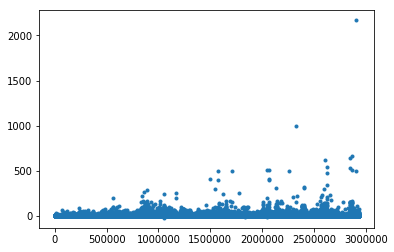

In [424]:
# raw item_cnt_day distribution
plt.plot(train_m.item_cnt_day, '.')

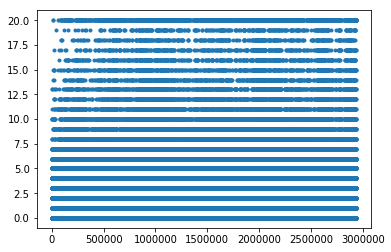

In [426]:
# winsorized item_cnt_day distribution
plt.plot(np.clip(train_m.item_cnt_day, 0, 20), '.')

# First Model: Compute Predictions as Previous Month Sale

In [61]:
train_m = pd.read_csv('./train_m.csv')
test_m = pd.read_csv('./test_m.csv')

In [62]:
train_m['dd'] = train_m.date.apply(lambda r: r.split('.')[0])
train_m['mm'] = train_m.date.apply(lambda r: r.split('.')[1])
train_m['yyyy'] = train_m.date.apply(lambda r: r.split('.')[2])

In [63]:
# Use this simple model to see the benchmark score!
train_oct = train_m[train_m['date_block_num']==33]
oct_sum = train_oct.groupby(['shop_id', 'item_id']).agg(['sum'])['item_cnt_day']['sum']
oct_df = oct_sum.reset_index()
res = test.merge(oct_df, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'], how='left')
res = res.drop(columns=['shop_id', 'item_id'])
res = res.rename(index=str, columns={"sum": "item_cnt_month"})
res = res.fillna(0)
#res.item_cnt_month.value_counts()
res['item_cnt_month'] = np.clip(res.item_cnt_month, 0, 20)
res.to_csv('./submission_prevmonth.csv', index=False)

In [23]:
train_m.to_csv('./train_m2.csv', index=False)
test_m.to_csv('./test_m2.csv', index=False)

# Feature Engineering

## Concatenate Train + Test, Create features from item_cnt_day and item_price

In [6]:
train_m2 = pd.read_csv('./train_m2.csv')
test_m2 = pd.read_csv('./test_m2.csv')

In [19]:
test_m2['yyyy'] = 2015
test_m2['mm'] = 11
test_m2['date_block_num'] = 34
train_m2['mm'] = train_m2['mm'].apply(lambda r: int(r))
train_m2['yyyy'] = train_m2['yyyy'].apply(lambda r: int(r))
train_m2.drop(columns=['dd'], inplace=True)

In [22]:
test_m22 = test_m2.copy()
test_m22['date'] = np.nan
test_m22['item_price'] = np.nan
test_m22['item_cnt_day'] = np.nan
test_m22.drop(columns=['ID'], inplace=True)
all_m2 = pd.concat([train_m2, test_m22], sort=False)
all_m2.to_csv('./all_m2.csv', index=False)

In [148]:
def compute_col_stat(df, groupby, vcol, op):
    gb_df = df.groupby(groupby).agg([op])[vcol][op]
    gb_df = gb_df.reset_index()
    return gb_df

def create_features(in_df, groupbys, newvcols, ops, targetcol, datecol):
    feas = []
    out_df = in_df
    for idx, groupby in enumerate(groupbys):
        for op in ops:
            print('Generating feature: ', groupby, '-', newvcols[idx], '-', op)
            new_col = newvcols[idx] + '_' + op
            feas.append(new_col)
            allcols = groupby + [targetcol]
            df = in_df[allcols]
            df = compute_col_stat(df, groupby, targetcol, op)
            df.rename(index=str, columns={op:new_col}, inplace=True)
            out_df = out_df.merge(df, left_on=groupby, right_on=groupby, how='left')
            #test2 = test2.merge(df_t, left_on=groupby, right_on=groupby, how='left')
            #train2[new_col] = train2[new_col].fillna(0)
            #test2[new_col] = test2[new_col].fillna(0)
    return (feas, out_df)
    print('Finished generating lag features.')

In [18]:
all_m2 = pd.read_csv('./all_m2.csv', dtype={'date':'str'})

## Mean Encoding

In [19]:
# Compute the monthly sum based on shop_id, item_id, item_category_id, shop_id + item_id
groupbys = [['date_block_num', 'shop_id'], ['date_block_num', 'item_id'], ['date_block_num', 'shop_id', 'item_id'], ['date_block_num', 'item_category_id']]
newvcols = ['shop_monthly', 'item_monthly', 'shop_item_monthly', 'item_cat_monthly']
datecol= 'date_block_num'
targetcol = 'item_cnt_day'
ops = ['sum']
features1, all_2 = create_features(all_m2, groupbys, newvcols, ops, targetcol, datecol)

Generating feature:  ['date_block_num', 'shop_id'] - shop_monthly - sum
Generating feature:  ['date_block_num', 'item_id'] - item_monthly - sum
Generating feature:  ['date_block_num', 'shop_id', 'item_id'] - shop_item_monthly - sum
Generating feature:  ['date_block_num', 'item_category_id'] - item_cat_monthly - sum


In [20]:
# Compute the statistics (mean/median/max/min/std) for item_price based on shop_id, item_id, item_category_id, shop_id + item_id
newvcols = ['shop_price', 'item_price', 'shop_item_price', 'item_cat_price']
targetcol = 'item_price'
ops = ['mean', 'median', 'max', 'min', 'std']
features2, all_2 = create_features(all_2, groupbys, newvcols, ops, targetcol, datecol)

Generating feature:  ['date_block_num', 'shop_id'] - shop_price - mean
Generating feature:  ['date_block_num', 'shop_id'] - shop_price - median
Generating feature:  ['date_block_num', 'shop_id'] - shop_price - max
Generating feature:  ['date_block_num', 'shop_id'] - shop_price - min
Generating feature:  ['date_block_num', 'shop_id'] - shop_price - std
Generating feature:  ['date_block_num', 'item_id'] - item_price - mean
Generating feature:  ['date_block_num', 'item_id'] - item_price - median
Generating feature:  ['date_block_num', 'item_id'] - item_price - max
Generating feature:  ['date_block_num', 'item_id'] - item_price - min
Generating feature:  ['date_block_num', 'item_id'] - item_price - std
Generating feature:  ['date_block_num', 'shop_id', 'item_id'] - shop_item_price - mean
Generating feature:  ['date_block_num', 'shop_id', 'item_id'] - shop_item_price - median
Generating feature:  ['date_block_num', 'shop_id', 'item_id'] - shop_item_price - max
Generating feature:  ['date_bl

In [23]:
all_2.to_csv('./all_2.csv', index=False)

In [24]:
# Drop duplicates of combination (date_block_num, shop_id, item_id), the rows shall be identical except 'date' column
all_2_cleaned = all_2.drop_duplicates(subset=['date_block_num', 'item_id', 'shop_id'], inplace=False)
all_2_cleaned.to_csv('./all_2_cleaned.csv', index=False)
len(all_2), len(all_2_cleaned)

(3150049, 1823324)

In [168]:
all_2_cleaned = pd.read_csv('./all_2_cleaned.csv', dtype={'date':'str'})

In [177]:
#For std features, the groupby.agg('std') is using ddof = 1, which will make std = NaN when there's only 1 data point. 
# We set them to zero here
std_feas = [f for f in features2 if 'std' in f]
print(std_feas)
for stdf in std_feas:
    all_2_cleaned[stdf] = all_2_cleaned[stdf].fillna(0)
    all_2_cleaned.loc[all_2_cleaned['date_block_num']==34, stdf] = np.nan

['shop_price_std', 'item_price_std', 'shop_item_price_std', 'item_cat_price_std']


In [181]:
all_2_cleaned.to_csv('./all_2_cleaned_filled.csv', index=False)

In [219]:
write_list(features1, './features1.txt')
write_list(features2, './features2.txt')

In [299]:
#Only need monthly data
all_2_monthly = all_2_cleaned.drop_duplicates(subset=['shop_id', 'item_id', 'date_block_num'])
all_2_monthly.to_csv('./all_2_monthly.csv', index=False)
print(len(all_2_monthly))
#all_2_monthly[all_2_monthly['shop_id']==40]

1823324


## Fill Missing Feature Values

In [15]:
all_2_monthly = pd.read_csv('./all_2_monthly.csv', dtype={'date':'str'})

In [8]:
features1 = read_list('./features1.txt')
features2 = read_list('./features2.txt')
all_base_features = features1 + features2
print(len(all_base_features))
shop_item_based = [f for f in all_base_features if 'shop_item' in f]
rest_features = set(all_base_features) - set(shop_item_based)
item_cat_based = [f for f in rest_features if 'item_cat' in f]
rest_features = set(rest_features) - set(item_cat_based)
item_based = [f for f in rest_features if 'item' in f]
rest_features = set(rest_features) - set(item_based)
shop_based = [f for f in rest_features if 'shop' in f]
sum_feas = [f for f in all_base_features if 'sum' in f]
rest_features = set(rest_features) - set(shop_based)
print('shop_item based: ', shop_item_based)
print('\nitem_cat based: ', item_cat_based)
print('\nshop based: ', shop_based)
print('\nitem based: ', item_based)
print(rest_features)
print(sum_feas)

24
shop_item based:  ['shop_item_monthly_sum', 'shop_item_price_mean', 'shop_item_price_median', 'shop_item_price_max', 'shop_item_price_min', 'shop_item_price_std']

item_cat based:  ['item_cat_price_std', 'item_cat_price_min', 'item_cat_price_median', 'item_cat_price_mean', 'item_cat_monthly_sum', 'item_cat_price_max']

shop based:  ['shop_price_max', 'shop_price_min', 'shop_price_std', 'shop_price_mean', 'shop_price_median', 'shop_monthly_sum']

item based:  ['item_price_min', 'item_price_mean', 'item_price_max', 'item_price_median', 'item_monthly_sum', 'item_price_std']
set()
['shop_monthly_sum', 'item_monthly_sum', 'shop_item_monthly_sum', 'item_cat_monthly_sum']


In [76]:
kcols = [['shop_id'], ['item_id'], ['shop_id', 'item_id'], ['item_category_id']]
[['date_block_num']+kc for kc in kcols]
base_feas = [shop_based, item_based, shop_item_based, item_cat_based]
#[bf+kc for bf, kc in zip(base_feas, kcols)]

In [16]:
# Create "grid" with columns
max_date_block = np.max(np.unique(all_2_monthly.date_block_num))
all_date_blocks = [d for d in range(0,max_date_block+1)]
index_cols = ['shop_id', 'item_id', 'date_block_num']
datecol = 'date_block_num'
# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in all_date_blocks:
    cur_shops = all_2_monthly.loc[all_2_monthly[datecol] == block_num, 'shop_id'].unique()
    cur_items = all_2_monthly.loc[all_2_monthly[datecol] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
print(grid.shape)

(11128050, 3)


In [17]:
all_2_merged = grid.merge(all_2_monthly, left_on = index_cols, right_on = index_cols, how = 'left')
all_2_merged.to_csv('./all_2_merged.csv', index=False)

In [194]:
all_2_merged = pd.read_csv('./all_2_merged.csv', dtype={'date':'str'})

In [200]:
#Create a mapping from item_id to item_category_id
#items['item_id'] = items.item_id.apply(lambda r: int(r))
#items['item_category_id'] = items.item_category_id.apply(lambda r: int(r))
#items_id2cat_map = dict(items[['item_id', 'item_category_id']].values)

# Fill NaN item_category_id
#all_2_merged.rename(index=str, columns={'item_category_id':'item_category_id_old'}, inplace=True)
all_2_merged = all_2_merged.drop(columns=['item_category_id_old'])
all_2_merged = all_2_merged.merge(items[['item_id', 'item_category_id']], left_on=['item_id'], right_on=['item_id'], how='left')

In [203]:
#Forward/Backward fill of missing values
kcols = [['shop_id'], ['item_id'], ['shop_id', 'item_id'], ['item_category_id']]
groupbys = [['date_block_num']+kc for kc in kcols]
base_feas = [shop_based, item_based, shop_item_based, item_cat_based]
gb_feas = [bf+kc for bf, kc in zip(base_feas, kcols)]
for idx, gb in enumerate(kcols):
    print('Working on group: ', gb)
    cols = base_feas[idx]
    cols = list(set(cols) - set(sum_feas)) #ignore 'sum' based features
    print('---- Columns to fill: ', cols)
    all_2_merged[cols] = all_2_merged.groupby(gb)[cols].ffill()[cols]
    all_2_merged[cols] = all_2_merged.groupby(gb)[cols].bfill()[cols]
    
print('Fill zero for sum-based features')
for sf in sum_feas:
    all_2_merged[sf] = all_2_merged[sf].fillna(0)    

Working on group:  ['shop_id']
---- Columns to fill:  ['shop_price_mean', 'shop_price_min', 'shop_price_std', 'shop_price_median', 'shop_price_max']
Working on group:  ['item_id']
---- Columns to fill:  ['item_price_mean', 'item_price_min', 'item_price_std', 'item_price_max', 'item_price_median']
Working on group:  ['shop_id', 'item_id']
---- Columns to fill:  ['shop_item_price_max', 'shop_item_price_median', 'shop_item_price_std', 'shop_item_price_mean', 'shop_item_price_min']
Working on group:  ['item_category_id']
---- Columns to fill:  ['item_cat_price_min', 'item_cat_price_std', 'item_cat_price_median', 'item_cat_price_mean', 'item_cat_price_max']
Fill zero for sum-based features


In [205]:
all_2_merged.to_csv('./all_2_merged_filled.csv', index=False)

In [6]:
all_2_merged = pd.read_csv('./all_2_merged_filled.csv', dtype={'date':'str'})

In [7]:
# Fill the rest NaN values with global median for each item_id
shop_item_cols = list(set(shop_item_based) - set(['shop_item_monthly_sum']))
item_median = all_2_merged.groupby(['item_id'])[shop_item_cols].agg(['median'])
item_median_df = item_median.reset_index()
item_median_df.columns = item_median_df.columns.droplevel(1)
for col in shop_item_cols:
    newcol = 'glb_' + col
    item_median_df[newcol] = item_median_df[col]
    item_median_df.drop(columns=[col], inplace=True)
    
all_2_merged = all_2_merged.merge(item_median_df, left_on=['item_id'], right_on=['item_id'], how='left')
all_2_merged.head().T

,0,1,2,3,4
shop_id,59,59,59,59,59
item_id,22154,2552,2554,2555,2564
date_block_num,0,0,0,0,0
date,02.01.2013,NaN,NaN,NaN,NaN
item_price,999,NaN,NaN,NaN,NaN
item_cnt_day,1,NaN,NaN,NaN,NaN
shop_name,"Ярославль ТЦ ""Альтаир""",NaN,NaN,NaN,NaN
item_name,ЯВЛЕНИЕ 2012 (BD),NaN,NaN,NaN,NaN
item_category_name,Кино - Blu-Ray,NaN,NaN,NaN,NaN
mm,1,NaN,NaN,NaN,NaN


In [30]:
#Use global median to fill the missing values
for col in shop_item_cols:
    newcol = 'glb_' + col
    print('process col: ', col, newcol)
    all_2_merged['sign_old'] = all_2_merged[col].apply(lambda r: 0 if np.isnan(r) else 1)
    all_2_merged['sign_new'] = 1-all_2_merged.sign_old
    all_2_merged[col] = all_2_merged[col].apply(lambda r: -999999 if np.isnan(r) else r)
    all_2_merged[col] = all_2_merged[col] * all_2_merged.sign_old + all_2_merged[newcol] * all_2_merged.sign_new
all_2_merged.head().T

process col:  shop_item_price_max glb_shop_item_price_max
process col:  shop_item_price_min glb_shop_item_price_min
process col:  shop_item_price_mean glb_shop_item_price_mean
process col:  shop_item_price_std glb_shop_item_price_std
process col:  shop_item_price_median glb_shop_item_price_median


,0,1,2,3,4
shop_id,59,59,59,59,59
item_id,22154,2552,2554,2555,2564
date_block_num,0,0,0,0,0
date,02.01.2013,NaN,NaN,NaN,NaN
item_price,999,NaN,NaN,NaN,NaN
item_cnt_day,1,NaN,NaN,NaN,NaN
shop_name,"Ярославль ТЦ ""Альтаир""",NaN,NaN,NaN,NaN
item_name,ЯВЛЕНИЕ 2012 (BD),NaN,NaN,NaN,NaN
item_category_name,Кино - Blu-Ray,NaN,NaN,NaN,NaN
mm,1,NaN,NaN,NaN,NaN


In [31]:
#Check how many values are NaN before month #34, count() skips NaN values
for f in all_base_features:
    print(f, len(all_2_merged[all_2_merged['date_block_num']<34]) - all_2_merged[all_2_merged['date_block_num']<34][f].count())

shop_monthly_sum 0
item_monthly_sum 0
shop_item_monthly_sum 0
item_cat_monthly_sum 0
shop_price_mean 0
shop_price_median 0
shop_price_max 0
shop_price_min 0
shop_price_std 0
item_price_mean 0
item_price_median 0
item_price_max 0
item_price_min 0
item_price_std 0
shop_item_price_mean 0
shop_item_price_median 0
shop_item_price_max 0
shop_item_price_min 0
shop_item_price_std 0
item_cat_price_mean 0
item_cat_price_median 0
item_cat_price_max 0
item_cat_price_min 0
item_cat_price_std 0


In [34]:
newcols = ['glb_' + col for col in shop_item_cols] + ['sign_old', 'sign_new']
all_2_merged.drop(columns=newcols, inplace=True)

In [35]:
all_2_merged.to_csv('./all_2_merged_filled_full.csv', index=False)

In [44]:
# Remove columns not used for now
all_2_merged.drop(columns=['date', 'yyyy', 'mm', 'item_price', 'item_cnt_day', 'shop_name', 'item_name', 'item_category_name'], inplace=True)
all_2_merged.to_csv('./all_2_merged_filled_cleaned.csv', index=False)

## Create Lagged Features

In [122]:
all_2_merged = pd.read_csv('./all_2_merged_filled_cleaned.csv', dtype={'date':'str'})

In [125]:
features1 = read_list('./features1.txt')
features2 = read_list('./features2.txt')
all_base_features = features1 + features2

kcols = [['shop_id'], ['item_id'], ['shop_id', 'item_id'], ['item_category_id']]
groupbys = [['date_block_num']+kc for kc in kcols]
base_feas = [shop_based, item_based, shop_item_based, item_cat_based]
gb_feas = [bf+kc for bf, kc in zip(base_feas, kcols)]
len(all_base_features)

24

### Create lagged features

In [ ]:
%%time
lags = [1,2,3,4,5,6,12]
test_date_num = 34
datecol= 'date_block_num'
print('original length of all_2_merged: ', len(all_2_merged))

for lag in lags:
    all_3_left = all_2_merged[['date_block_num', 'shop_id', 'item_id', 'item_category_id']].copy()
    print('******** lag ' + str(lag) + ' ********')
    for idx, groupby in enumerate(groupbys):
        feas = base_feas[idx]
        kcol = kcols[idx]
        print('Working on groups: ', groupby)
        print('list of features to work on: ', feas)
        cols = groupby + feas
        all_3_right = all_2_merged[cols]
        all_3_right = all_3_right.drop_duplicates(subset=groupby, inplace=False)
        print('# of rows for groupby: ', len(all_3_right))
        
        #Use previous value in the order of date_block_num to fill data that not handled by normal lag operation
        #e.g. date_block_num: 3,5,7,8,9,10 can't fill lag of month 5, 7, 12 etc.
        all_3_prev = all_3_right.copy()
        for f in feas:
            prev_col = 'prev_' + f
            all_3_prev[prev_col] = all_3_prev.groupby(kcol)[f].shift(lag)
            #glb_col = 'glb_' + f #apply global median for first
            #df = all_3_prev.groupby(kcol)[f].median() #Data Leak here, need to handle it after using block number
            
            #df = df.reset_index()
            #df.rename(columns={f:glb_col}, inplace=True)
            #all_3_prev = all_3_prev.merge(df, left_on=kcol, right_on=kcol, how='left')
            #all_3_prev[prev_col] = all_3_prev.apply(lambda r: r[glb_col] if np.isnan(r[prev_col]) else r[prev_col] , axis=1)
            #all_3_prev.drop(columns=[glb_col], inplace=True)
            
        all_3_prev.drop(columns=feas, inplace=True)
    
        print('Generating lag features: ', groupby, '-', lag)        
        all_3_right[datecol] = all_3_right[datecol] + lag
        all_3_left = all_3_left.merge(all_3_right, left_on = groupby, right_on = groupby, how='left' )
        all_3_left = all_3_left.merge(all_3_prev, left_on = groupby, right_on = groupby, how='left' )
            
        print('Use previous value to fill NaNs.')
        for f in feas:
            prev_col = 'prev_' + f
            if 'sum' in f:
                all_3_left[f] = all_3_left[f].fillna(0)
            else:
                all_3_left['sign_old'] = all_3_left[f].apply(lambda r: 0 if np.isnan(r) else 1)
                all_3_left['sign_new'] = 1 - all_3_left['sign_old']
                all_3_left[f] = all_3_left[f].apply(lambda r: -999 if np.isnan(r) else r)
                all_3_left[f] = all_3_left['sign_old'] * all_3_left[f] + all_3_left['sign_new'] * all_3_left[prev_col]
            all_3_left.drop(columns=[prev_col], inplace=True)
        
        all_3_left.drop(columns=['sign_old', 'sign_new'], inplace=True)
            
        col_rename = {old:old+'_lag_' + str(lag) for old in feas}
        all_3_left.rename(index=str, columns=col_rename, inplace=True)
        print('--------------------------')

    
    lagged_filename = './all_3_lag_' + str(lag) + '.csv'
    print('Saving data to file: ', lagged_filename)
    all_3_left.to_csv(lagged_filename, index=False)
    
print('Finished generating lag features.')

## Fill the Missing Numbers in lagged Features

In [136]:
#Generate global medians for all features
ds, fs, ms = [], [], []
for d in range(test_date_num):
    for f in all_base_features:
        v = all_2_merged[all_2_merged['date_block_num']==d][f].median()
        ds.append(d)
        fs.append(f)
        ms.append(v)
glb_df = pd.DataFrame({'date_block_num':ds, 'feature':fs, 'median':ms})        
glb_df.to_csv('./global_medians.csv', index=False)

,date_block_num,feature,median
0,0,shop_monthly_sum,0.000000
1,0,item_monthly_sum,0.000000
2,0,shop_item_monthly_sum,0.000000
3,0,item_cat_monthly_sum,0.000000
4,0,shop_price_mean,713.569287
5,0,shop_price_median,399.000000
6,0,shop_price_max,15990.000000
7,0,shop_price_min,25.000000
8,0,shop_price_std,1194.524199
9,0,item_price_mean,287.545455


In [40]:
lags = [1,2,3,4,5,6,12]
test_date_num = 34
features1 = read_list('./features1.txt')
features2 = read_list('./features2.txt')
all_base_features = features1 + features2
glb_df = pd.read_csv('./global_medians.csv')
for lag in lags:
    lagged_filename = './all_3_lag_' + str(lag) + '.csv'
    all_3_lagged = pd.read_csv(lagged_filename, dtype={'date':'str'})
    print('Fill missing values in: ', lagged_filename)
    for d in range(lag, test_date_num+1):
        for f in all_base_features:
            lag_f = f + '_lag_' + str(lag)
            v = glb_df[(glb_df['date_block_num']==d-lag)&(glb_df['feature']==f)]['median'] #use last month median
            all_3_lagged.loc[(all_3_lagged['date_block_num']==d)&(all_3_lagged[lag_f].isnull()), lag_f] = v.values[0]
    lagged_fn = './all_3_filled_lag_' + str(lag) + '.csv'
    all_3_lagged.to_csv(lagged_fn, index=False)

Fill missing values in:  ./all_3_lag_1.csv
Fill missing values in:  ./all_3_lag_2.csv
Fill missing values in:  ./all_3_lag_3.csv
Fill missing values in:  ./all_3_lag_4.csv
Fill missing values in:  ./all_3_lag_5.csv
Fill missing values in:  ./all_3_lag_6.csv
Fill missing values in:  ./all_3_lag_12.csv


In [42]:
check_nans(all_3_lagged[all_3_lagged['date_block_num']>11])

Completed checking for NaNs.


# Remove 2013 data

In [43]:
lags = [1,2,3,4,5,6,12]
for lag in lags:
    lagged_filename = './all_3_filled_lag_' + str(lag) + '.csv'
    print('Removing 2013 data for ', lagged_filename)
    all_3_lagged = pd.read_csv(lagged_filename, dtype={'date':'str'})
    all_3_reduced = all_3_lagged[all_3_lagged['date_block_num']>=12]
    outf = './all_3_reduced_lag_' + str(lag) + '.csv'
    all_3_reduced.to_csv(outf, index=False)

Removing 2013 data for  ./all_3_filled_lag_1.csv
Removing 2013 data for  ./all_3_filled_lag_2.csv
Removing 2013 data for  ./all_3_filled_lag_3.csv
Removing 2013 data for  ./all_3_filled_lag_4.csv
Removing 2013 data for  ./all_3_filled_lag_5.csv
Removing 2013 data for  ./all_3_filled_lag_6.csv
Removing 2013 data for  ./all_3_filled_lag_12.csv


# Ensemble Setup

### Create winsorized targets for all data

In [437]:
# Load targets
all_2_merged = pd.read_csv('./all_2_merged_filled_cleaned.csv', dtype={'date':'str'})
all_3_targets = all_2_merged[['date_block_num', 'shop_id', 'item_id', 'shop_item_monthly_sum']].copy()
all_3_targets.rename(columns={'shop_item_monthly_sum':'target'}, inplace=True)
all_3_targets.to_csv('./all_3_targets.csv', index=False)
all_3_targets['target'] = np.clip(all_3_targets['target'], 0, 20)
all_3_targets.to_csv('./all_3_targets_clipped.csv', index=False)

In [12]:
all_3_targets = pd.read_csv('./all_3_targets_clipped.csv')

### Driver function to compute the meta features from different first level models

In [394]:
def compute_meta_features(model, all_3_targets, **kwargs):
    print('Compute meta features for model: ', model)
    drop_cols = ['date_block_num', 'target']
    target = 'target'
    merge_cols = ['date_block_num', 'shop_id', 'item_id']
    lags = [1, 2,3,4,5,6,12]
    for lag in lags:
        fn = './all_3_reduced_lag_' + str(lag) + '.csv'
        print('Loading lag ', lag, ' features from file: ', fn)
        all_3_reduced = pd.read_csv(fn, dtype={'date':'str'})
        all_3 = all_3_reduced.merge(all_3_targets, left_on = merge_cols, right_on = merge_cols, how='left')
        features = list(set(all_3.columns)-set(drop_cols))
        print('Computing meta features with following features: ', features)
        metas = create_meta_features_on_lag(model, all_3, features, target, datecol, merge_cols, lag, **kwargs)
        if model == 'lasso':
            alpha = kwargs['alpha']
            meta_file = './meta_' + str(model) + '_' + str(alpha) + '_lag_' + str(lag) + '.csv'
        else:
            meta_file = './meta_200_' + str(model) + '_lag_' + str(lag) + '.csv'
        print('Writing meta features to file: ', meta_file)
        metas.to_csv(meta_file, index=False)

### Run first level model on months 27-34, and with different lags

In [396]:
#For a given model and a set of features, generate meta_features
def create_meta_features_on_lag(model, df_feas, features, target, datecol, merge_cols, lag, **kwargs):
    level2_target_months = [27, 28, 29, 30, 31, 32, 33, 34]
    metas = df_feas[df_feas[datecol]>=27][merge_cols].copy()
    metas[model] = np.nan
    for tm2 in level2_target_months:
        print('processing target month: ', tm2)
        # Get train data for each target month
        sub_train = df_feas[df_feas[datecol]<tm2]
        sub_test = df_feas[df_feas[datecol]==tm2]

        # train model
        preds, md = run_model(model, sub_train, sub_test, features, target, **kwargs)
        if model == 'lasso':
            alpha = kwargs['alpha']
            model_file = './meta_' + model + '_' + str(alpha) + '_lag_' + str(lag) + '_month_' + str(tm2) + '.dat'
        else:
            model_file = './meta_200_' + model + '_lag_' + str(lag) + '_month_' + str(tm2) + '.dat'
        pickle.dump(md, open(model_file, "wb"))
        #loaded_model = pickle.load(open(model_file, "rb"))
        metas.loc[(metas[datecol]==tm2), model] = np.clip(preds, 0, 20)
    return metas

### Define different first level models here

In [392]:
def run_model(model, train, test, features, target, **kwargs):
    if model == 'lr':
        preds, md = run_lr(train, test, features, target)
    elif model == 'lasso':        
        preds, md = run_lasso(train, test, features, target, kwargs['alpha'])        
    elif model == 'xgb':
        preds, md = run_xgb(train, test, features, target)
    elif model == 'rf':
        preds, md = run_rf(train, test, features, target)
    return (preds, md)

def run_lr(train, test, features, target):
    lr = LinearRegression()
    x_train = train[features].values
    y_train = train[target].values
    x_test = test[features].values
    x_train_scaled = preprocessing.scale(x_train)
    x_test_scaled = preprocessing.scale(x_test)
    lr.fit(x_train_scaled, y_train)
    pred_lr = lr.predict(x_test_scaled)
    return (pred_lr, lr)

def run_lasso(train, test, features, target, alpha):
    clf = Lasso(alpha = alpha)
    x_train = train[features].values
    y_train = train[target].values
    x_test = test[features].values
    x_train_scaled = preprocessing.scale(x_train)
    x_test_scaled = preprocessing.scale(x_test)
    clf.fit(x_train_scaled, y_train)
    pred_clf = clf.predict(x_test_scaled)
    return (pred_clf, clf)
    
def run_xgb(train, test, features, target):
    x_train = train[features]
    y_train = train[target]
    x_test = test[features]
    
    #100, 5
    #500, 7
    #300, 8
    bst = xgb.XGBRegressor(n_estimators=300, learning_rate=0.02, gamma=0, subsample=0.8,
                           colsample_bytree=1.0, max_depth=8, silent=False, n_jobs=4)
    bst.fit(x_train,y_train, verbose=True, eval_set=[(x_train, y_train)], eval_metric=['rmse'])    
    pred = bst.predict(x_test)
    return (pred, bst)

def run_rf(train, test, features, target):
    #Random forest
    x_train = train[features]
    y_train = train[target]
    x_test = test[features]    
    regr = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=200)
    regr.fit(x_train, y_train)
    pred = regr.predict(x_test)
    return (pred, regr)

### Add plain linear regression model to ensemble

In [246]:
%%time
model = 'lr'
compute_meta_features(model, all_3_targets)

Compute meta features for model:  lr
Loading lag  1  features from file:  ./all_3_reduced_lag_1.csv
Computing meta features with following features:  ['item_price_mean_lag_1', 'shop_item_price_median_lag_1', 'shop_item_price_std_lag_1', 'shop_price_min_lag_1', 'shop_item_price_max_lag_1', 'shop_item_monthly_sum_lag_1', 'item_monthly_sum_lag_1', 'item_cat_price_mean_lag_1', 'shop_id', 'item_cat_price_std_lag_1', 'shop_price_median_lag_1', 'item_cat_monthly_sum_lag_1', 'shop_item_price_mean_lag_1', 'item_price_min_lag_1', 'item_price_std_lag_1', 'item_category_id', 'item_price_median_lag_1', 'item_cat_price_min_lag_1', 'shop_price_max_lag_1', 'item_cat_price_median_lag_1', 'shop_monthly_sum_lag_1', 'item_price_max_lag_1', 'item_id', 'shop_item_price_min_lag_1', 'shop_price_std_lag_1', 'shop_price_mean_lag_1', 'item_cat_price_max_lag_1']
processing target month:  27
processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processi

### Add GBDT models to ensemble

In [284]:
# Run this with various number of estimators and max_depth
%%time
model = 'xgb'
compute_meta_features(model, all_3_targets)

Compute meta features for model:  xgb
Loading lag  1  features from file:  ./all_3_reduced_lag_1.csv
Computing meta features with following features:  ['item_price_mean_lag_1', 'shop_item_price_median_lag_1', 'shop_item_price_std_lag_1', 'shop_price_min_lag_1', 'shop_item_price_max_lag_1', 'shop_item_monthly_sum_lag_1', 'item_monthly_sum_lag_1', 'item_cat_price_mean_lag_1', 'shop_id', 'item_cat_price_std_lag_1', 'shop_price_median_lag_1', 'item_cat_monthly_sum_lag_1', 'shop_item_price_mean_lag_1', 'item_price_min_lag_1', 'item_price_std_lag_1', 'item_category_id', 'item_price_median_lag_1', 'item_cat_price_min_lag_1', 'shop_price_max_lag_1', 'item_cat_price_median_lag_1', 'shop_monthly_sum_lag_1', 'item_price_max_lag_1', 'item_id', 'shop_item_price_min_lag_1', 'shop_price_std_lag_1', 'shop_price_mean_lag_1', 'item_cat_price_max_lag_1']
processing target month:  27
[0]	validation_0-rmse:1.22446
[1]	validation_0-rmse:1.21397
[2]	validation_0-rmse:1.20378
[3]	validation_0-rmse:1.19393
[4]

[227]	validation_0-rmse:0.857255
[228]	validation_0-rmse:0.857082
[229]	validation_0-rmse:0.856764
[230]	validation_0-rmse:0.85658
[231]	validation_0-rmse:0.856392
[232]	validation_0-rmse:0.856174
[233]	validation_0-rmse:0.856007
[234]	validation_0-rmse:0.855824
[235]	validation_0-rmse:0.855607
[236]	validation_0-rmse:0.855257
[237]	validation_0-rmse:0.854828
[238]	validation_0-rmse:0.854686
[239]	validation_0-rmse:0.854537
[240]	validation_0-rmse:0.854204
[241]	validation_0-rmse:0.853905
[242]	validation_0-rmse:0.853687
[243]	validation_0-rmse:0.853542
[244]	validation_0-rmse:0.853406
[245]	validation_0-rmse:0.853244
[246]	validation_0-rmse:0.853105
[247]	validation_0-rmse:0.852729
[248]	validation_0-rmse:0.85259
[249]	validation_0-rmse:0.85214
[250]	validation_0-rmse:0.851864
[251]	validation_0-rmse:0.851664
[252]	validation_0-rmse:0.851232
[253]	validation_0-rmse:0.851069
[254]	validation_0-rmse:0.850896
[255]	validation_0-rmse:0.850714
[256]	validation_0-rmse:0.850451
[257]	validat

[180]	validation_0-rmse:0.87004
[181]	validation_0-rmse:0.869708
[182]	validation_0-rmse:0.869435
[183]	validation_0-rmse:0.868979
[184]	validation_0-rmse:0.868614
[185]	validation_0-rmse:0.868346
[186]	validation_0-rmse:0.868147
[187]	validation_0-rmse:0.867826
[188]	validation_0-rmse:0.86742
[189]	validation_0-rmse:0.867032
[190]	validation_0-rmse:0.866694
[191]	validation_0-rmse:0.866479
[192]	validation_0-rmse:0.86623
[193]	validation_0-rmse:0.865954
[194]	validation_0-rmse:0.865742
[195]	validation_0-rmse:0.865376
[196]	validation_0-rmse:0.864909
[197]	validation_0-rmse:0.864547
[198]	validation_0-rmse:0.864296
[199]	validation_0-rmse:0.86412
[200]	validation_0-rmse:0.863901
[201]	validation_0-rmse:0.863445
[202]	validation_0-rmse:0.863192
[203]	validation_0-rmse:0.862821
[204]	validation_0-rmse:0.862615
[205]	validation_0-rmse:0.862393
[206]	validation_0-rmse:0.862037
[207]	validation_0-rmse:0.861815
[208]	validation_0-rmse:0.861487
[209]	validation_0-rmse:0.861284
[210]	validati

[133]	validation_0-rmse:0.885537
[134]	validation_0-rmse:0.885194
[135]	validation_0-rmse:0.884888
[136]	validation_0-rmse:0.884571
[137]	validation_0-rmse:0.884268
[138]	validation_0-rmse:0.883984
[139]	validation_0-rmse:0.883677
[140]	validation_0-rmse:0.883348
[141]	validation_0-rmse:0.883052
[142]	validation_0-rmse:0.882776
[143]	validation_0-rmse:0.882404
[144]	validation_0-rmse:0.881996
[145]	validation_0-rmse:0.88169
[146]	validation_0-rmse:0.881364
[147]	validation_0-rmse:0.880891
[148]	validation_0-rmse:0.880635
[149]	validation_0-rmse:0.88039
[150]	validation_0-rmse:0.879997
[151]	validation_0-rmse:0.8796
[152]	validation_0-rmse:0.879336
[153]	validation_0-rmse:0.87902
[154]	validation_0-rmse:0.878494
[155]	validation_0-rmse:0.878129
[156]	validation_0-rmse:0.877854
[157]	validation_0-rmse:0.877545
[158]	validation_0-rmse:0.877137
[159]	validation_0-rmse:0.876858
[160]	validation_0-rmse:0.876524
[161]	validation_0-rmse:0.876162
[162]	validation_0-rmse:0.875923
[163]	validatio

[86]	validation_0-rmse:0.906939
[87]	validation_0-rmse:0.906241
[88]	validation_0-rmse:0.905556
[89]	validation_0-rmse:0.904798
[90]	validation_0-rmse:0.904085
[91]	validation_0-rmse:0.903381
[92]	validation_0-rmse:0.90272
[93]	validation_0-rmse:0.901991
[94]	validation_0-rmse:0.901262
[95]	validation_0-rmse:0.900553
[96]	validation_0-rmse:0.899813
[97]	validation_0-rmse:0.899184
[98]	validation_0-rmse:0.898488
[99]	validation_0-rmse:0.897881
[100]	validation_0-rmse:0.897295
[101]	validation_0-rmse:0.896727
[102]	validation_0-rmse:0.896191
[103]	validation_0-rmse:0.895644
[104]	validation_0-rmse:0.895017
[105]	validation_0-rmse:0.894459
[106]	validation_0-rmse:0.893935
[107]	validation_0-rmse:0.893405
[108]	validation_0-rmse:0.892943
[109]	validation_0-rmse:0.89241
[110]	validation_0-rmse:0.891937
[111]	validation_0-rmse:0.891504
[112]	validation_0-rmse:0.891029
[113]	validation_0-rmse:0.890587
[114]	validation_0-rmse:0.890132
[115]	validation_0-rmse:0.889694
[116]	validation_0-rmse:0.

[38]	validation_0-rmse:0.976865
[39]	validation_0-rmse:0.973942
[40]	validation_0-rmse:0.971147
[41]	validation_0-rmse:0.968356
[42]	validation_0-rmse:0.965666
[43]	validation_0-rmse:0.963053
[44]	validation_0-rmse:0.960548
[45]	validation_0-rmse:0.958114
[46]	validation_0-rmse:0.955819
[47]	validation_0-rmse:0.95359
[48]	validation_0-rmse:0.951393
[49]	validation_0-rmse:0.94926
[50]	validation_0-rmse:0.947193
[51]	validation_0-rmse:0.945166
[52]	validation_0-rmse:0.943251
[53]	validation_0-rmse:0.941405
[54]	validation_0-rmse:0.93957
[55]	validation_0-rmse:0.93778
[56]	validation_0-rmse:0.936066
[57]	validation_0-rmse:0.934406
[58]	validation_0-rmse:0.932809
[59]	validation_0-rmse:0.931241
[60]	validation_0-rmse:0.929728
[61]	validation_0-rmse:0.92827
[62]	validation_0-rmse:0.926808
[63]	validation_0-rmse:0.925393
[64]	validation_0-rmse:0.924008
[65]	validation_0-rmse:0.922697
[66]	validation_0-rmse:0.921376
[67]	validation_0-rmse:0.9201
[68]	validation_0-rmse:0.918887
[69]	validation

[290]	validation_0-rmse:0.83876
[291]	validation_0-rmse:0.838653
[292]	validation_0-rmse:0.83837
[293]	validation_0-rmse:0.838275
[294]	validation_0-rmse:0.837996
[295]	validation_0-rmse:0.837871
[296]	validation_0-rmse:0.837528
[297]	validation_0-rmse:0.837377
[298]	validation_0-rmse:0.837249
[299]	validation_0-rmse:0.837108
processing target month:  32
[0]	validation_0-rmse:1.19762
[1]	validation_0-rmse:1.18756
[2]	validation_0-rmse:1.17776
[3]	validation_0-rmse:1.16845
[4]	validation_0-rmse:1.15929
[5]	validation_0-rmse:1.15041
[6]	validation_0-rmse:1.14193
[7]	validation_0-rmse:1.1336
[8]	validation_0-rmse:1.12546
[9]	validation_0-rmse:1.11774
[10]	validation_0-rmse:1.11016
[11]	validation_0-rmse:1.10277
[12]	validation_0-rmse:1.09566
[13]	validation_0-rmse:1.08883
[14]	validation_0-rmse:1.08224
[15]	validation_0-rmse:1.07589
[16]	validation_0-rmse:1.06977
[17]	validation_0-rmse:1.0638
[18]	validation_0-rmse:1.058
[19]	validation_0-rmse:1.05231
[20]	validation_0-rmse:1.04686
[21]	v

[243]	validation_0-rmse:0.844556
[244]	validation_0-rmse:0.84437
[245]	validation_0-rmse:0.844221
[246]	validation_0-rmse:0.844027
[247]	validation_0-rmse:0.84389
[248]	validation_0-rmse:0.843685
[249]	validation_0-rmse:0.84346
[250]	validation_0-rmse:0.843285
[251]	validation_0-rmse:0.842917
[252]	validation_0-rmse:0.842762
[253]	validation_0-rmse:0.842472
[254]	validation_0-rmse:0.842369
[255]	validation_0-rmse:0.842226
[256]	validation_0-rmse:0.842027
[257]	validation_0-rmse:0.841826
[258]	validation_0-rmse:0.841613
[259]	validation_0-rmse:0.841522
[260]	validation_0-rmse:0.841362
[261]	validation_0-rmse:0.841004
[262]	validation_0-rmse:0.840847
[263]	validation_0-rmse:0.84073
[264]	validation_0-rmse:0.840492
[265]	validation_0-rmse:0.840382
[266]	validation_0-rmse:0.840182
[267]	validation_0-rmse:0.840018
[268]	validation_0-rmse:0.839929
[269]	validation_0-rmse:0.839761
[270]	validation_0-rmse:0.839583
[271]	validation_0-rmse:0.839329
[272]	validation_0-rmse:0.839239
[273]	validati

[196]	validation_0-rmse:0.857238
[197]	validation_0-rmse:0.856969
[198]	validation_0-rmse:0.85682
[199]	validation_0-rmse:0.856631
[200]	validation_0-rmse:0.856395
[201]	validation_0-rmse:0.856181
[202]	validation_0-rmse:0.855901
[203]	validation_0-rmse:0.855716
[204]	validation_0-rmse:0.855319
[205]	validation_0-rmse:0.855136
[206]	validation_0-rmse:0.854929
[207]	validation_0-rmse:0.85478
[208]	validation_0-rmse:0.854567
[209]	validation_0-rmse:0.854281
[210]	validation_0-rmse:0.854069
[211]	validation_0-rmse:0.853858
[212]	validation_0-rmse:0.853554
[213]	validation_0-rmse:0.853402
[214]	validation_0-rmse:0.853197
[215]	validation_0-rmse:0.853017
[216]	validation_0-rmse:0.852845
[217]	validation_0-rmse:0.852598
[218]	validation_0-rmse:0.852369
[219]	validation_0-rmse:0.8522
[220]	validation_0-rmse:0.851927
[221]	validation_0-rmse:0.85169
[222]	validation_0-rmse:0.851465
[223]	validation_0-rmse:0.851084
[224]	validation_0-rmse:0.850939
[225]	validation_0-rmse:0.850709
[226]	validatio

[149]	validation_0-rmse:0.873563
[150]	validation_0-rmse:0.873202
[151]	validation_0-rmse:0.872921
[152]	validation_0-rmse:0.872675
[153]	validation_0-rmse:0.872346
[154]	validation_0-rmse:0.871915
[155]	validation_0-rmse:0.871575
[156]	validation_0-rmse:0.871278
[157]	validation_0-rmse:0.870977
[158]	validation_0-rmse:0.870668
[159]	validation_0-rmse:0.870387
[160]	validation_0-rmse:0.870084
[161]	validation_0-rmse:0.869825
[162]	validation_0-rmse:0.869544
[163]	validation_0-rmse:0.869164
[164]	validation_0-rmse:0.868747
[165]	validation_0-rmse:0.868481
[166]	validation_0-rmse:0.868145
[167]	validation_0-rmse:0.8679
[168]	validation_0-rmse:0.867651
[169]	validation_0-rmse:0.867299
[170]	validation_0-rmse:0.866958
[171]	validation_0-rmse:0.866697
[172]	validation_0-rmse:0.866416
[173]	validation_0-rmse:0.866057
[174]	validation_0-rmse:0.865717
[175]	validation_0-rmse:0.865505
[176]	validation_0-rmse:0.865257
[177]	validation_0-rmse:0.865032
[178]	validation_0-rmse:0.864752
[179]	valida

[76]	validation_0-rmse:0.98981
[77]	validation_0-rmse:0.988823
[78]	validation_0-rmse:0.987981
[79]	validation_0-rmse:0.987224
[80]	validation_0-rmse:0.986469
[81]	validation_0-rmse:0.985544
[82]	validation_0-rmse:0.984777
[83]	validation_0-rmse:0.983822
[84]	validation_0-rmse:0.983165
[85]	validation_0-rmse:0.982461
[86]	validation_0-rmse:0.981724
[87]	validation_0-rmse:0.980929
[88]	validation_0-rmse:0.980267
[89]	validation_0-rmse:0.979636
[90]	validation_0-rmse:0.978974
[91]	validation_0-rmse:0.978353
[92]	validation_0-rmse:0.977685
[93]	validation_0-rmse:0.97708
[94]	validation_0-rmse:0.976428
[95]	validation_0-rmse:0.975718
[96]	validation_0-rmse:0.975179
[97]	validation_0-rmse:0.974572
[98]	validation_0-rmse:0.973953
[99]	validation_0-rmse:0.973318
[100]	validation_0-rmse:0.972681
[101]	validation_0-rmse:0.9721
[102]	validation_0-rmse:0.971542
[103]	validation_0-rmse:0.971059
[104]	validation_0-rmse:0.970479
[105]	validation_0-rmse:0.969974
[106]	validation_0-rmse:0.969543
[107]

[27]	validation_0-rmse:1.07432
[28]	validation_0-rmse:1.07099
[29]	validation_0-rmse:1.06774
[30]	validation_0-rmse:1.06461
[31]	validation_0-rmse:1.06165
[32]	validation_0-rmse:1.05882
[33]	validation_0-rmse:1.0559
[34]	validation_0-rmse:1.05301
[35]	validation_0-rmse:1.05024
[36]	validation_0-rmse:1.04759
[37]	validation_0-rmse:1.04507
[38]	validation_0-rmse:1.0426
[39]	validation_0-rmse:1.04023
[40]	validation_0-rmse:1.03799
[41]	validation_0-rmse:1.03576
[42]	validation_0-rmse:1.03356
[43]	validation_0-rmse:1.03147
[44]	validation_0-rmse:1.02933
[45]	validation_0-rmse:1.02731
[46]	validation_0-rmse:1.02543
[47]	validation_0-rmse:1.02361
[48]	validation_0-rmse:1.02185
[49]	validation_0-rmse:1.02011
[50]	validation_0-rmse:1.0184
[51]	validation_0-rmse:1.01675
[52]	validation_0-rmse:1.01518
[53]	validation_0-rmse:1.01362
[54]	validation_0-rmse:1.01214
[55]	validation_0-rmse:1.01071
[56]	validation_0-rmse:1.00935
[57]	validation_0-rmse:1.00792
[58]	validation_0-rmse:1.00664
[59]	valida

[280]	validation_0-rmse:0.922235
[281]	validation_0-rmse:0.922124
[282]	validation_0-rmse:0.921937
[283]	validation_0-rmse:0.921707
[284]	validation_0-rmse:0.921651
[285]	validation_0-rmse:0.921529
[286]	validation_0-rmse:0.921462
[287]	validation_0-rmse:0.921256
[288]	validation_0-rmse:0.921138
[289]	validation_0-rmse:0.920847
[290]	validation_0-rmse:0.920617
[291]	validation_0-rmse:0.920301
[292]	validation_0-rmse:0.920119
[293]	validation_0-rmse:0.919991
[294]	validation_0-rmse:0.919919
[295]	validation_0-rmse:0.919832
[296]	validation_0-rmse:0.91963
[297]	validation_0-rmse:0.919543
[298]	validation_0-rmse:0.919409
[299]	validation_0-rmse:0.91909
processing target month:  29
[0]	validation_0-rmse:1.2167
[1]	validation_0-rmse:1.20869
[2]	validation_0-rmse:1.20097
[3]	validation_0-rmse:1.19351
[4]	validation_0-rmse:1.18624
[5]	validation_0-rmse:1.17923
[6]	validation_0-rmse:1.17244
[7]	validation_0-rmse:1.16589
[8]	validation_0-rmse:1.15949
[9]	validation_0-rmse:1.15333
[10]	validatio

[234]	validation_0-rmse:0.92667
[235]	validation_0-rmse:0.926401
[236]	validation_0-rmse:0.926246
[237]	validation_0-rmse:0.926109
[238]	validation_0-rmse:0.925794
[239]	validation_0-rmse:0.925671
[240]	validation_0-rmse:0.925557
[241]	validation_0-rmse:0.925214
[242]	validation_0-rmse:0.925102
[243]	validation_0-rmse:0.924957
[244]	validation_0-rmse:0.924813
[245]	validation_0-rmse:0.924674
[246]	validation_0-rmse:0.924464
[247]	validation_0-rmse:0.92434
[248]	validation_0-rmse:0.924202
[249]	validation_0-rmse:0.924081
[250]	validation_0-rmse:0.923937
[251]	validation_0-rmse:0.923763
[252]	validation_0-rmse:0.92355
[253]	validation_0-rmse:0.923463
[254]	validation_0-rmse:0.923368
[255]	validation_0-rmse:0.923295
[256]	validation_0-rmse:0.923003
[257]	validation_0-rmse:0.922739
[258]	validation_0-rmse:0.922404
[259]	validation_0-rmse:0.922272
[260]	validation_0-rmse:0.921943
[261]	validation_0-rmse:0.921752
[262]	validation_0-rmse:0.921499
[263]	validation_0-rmse:0.921373
[264]	validat

[188]	validation_0-rmse:0.935674
[189]	validation_0-rmse:0.935493
[190]	validation_0-rmse:0.935328
[191]	validation_0-rmse:0.935119
[192]	validation_0-rmse:0.934901
[193]	validation_0-rmse:0.934559
[194]	validation_0-rmse:0.934167
[195]	validation_0-rmse:0.933975
[196]	validation_0-rmse:0.933621
[197]	validation_0-rmse:0.93332
[198]	validation_0-rmse:0.93293
[199]	validation_0-rmse:0.9327
[200]	validation_0-rmse:0.932411
[201]	validation_0-rmse:0.93222
[202]	validation_0-rmse:0.932067
[203]	validation_0-rmse:0.931859
[204]	validation_0-rmse:0.931582
[205]	validation_0-rmse:0.931427
[206]	validation_0-rmse:0.931072
[207]	validation_0-rmse:0.930878
[208]	validation_0-rmse:0.930676
[209]	validation_0-rmse:0.930262
[210]	validation_0-rmse:0.930078
[211]	validation_0-rmse:0.929916
[212]	validation_0-rmse:0.929785
[213]	validation_0-rmse:0.929622
[214]	validation_0-rmse:0.92921
[215]	validation_0-rmse:0.929022
[216]	validation_0-rmse:0.928663
[217]	validation_0-rmse:0.928427
[218]	validation

[142]	validation_0-rmse:0.944552
[143]	validation_0-rmse:0.944167
[144]	validation_0-rmse:0.943842
[145]	validation_0-rmse:0.943584
[146]	validation_0-rmse:0.94333
[147]	validation_0-rmse:0.943054
[148]	validation_0-rmse:0.942665
[149]	validation_0-rmse:0.942434
[150]	validation_0-rmse:0.942117
[151]	validation_0-rmse:0.941855
[152]	validation_0-rmse:0.941428
[153]	validation_0-rmse:0.941121
[154]	validation_0-rmse:0.940747
[155]	validation_0-rmse:0.940436
[156]	validation_0-rmse:0.939966
[157]	validation_0-rmse:0.939621
[158]	validation_0-rmse:0.939375
[159]	validation_0-rmse:0.939096
[160]	validation_0-rmse:0.938779
[161]	validation_0-rmse:0.93852
[162]	validation_0-rmse:0.938244
[163]	validation_0-rmse:0.937841
[164]	validation_0-rmse:0.937587
[165]	validation_0-rmse:0.937295
[166]	validation_0-rmse:0.937067
[167]	validation_0-rmse:0.936807
[168]	validation_0-rmse:0.936459
[169]	validation_0-rmse:0.936191
[170]	validation_0-rmse:0.935859
[171]	validation_0-rmse:0.935459
[172]	valida

[96]	validation_0-rmse:0.95969
[97]	validation_0-rmse:0.959169
[98]	validation_0-rmse:0.958612
[99]	validation_0-rmse:0.95801
[100]	validation_0-rmse:0.957509
[101]	validation_0-rmse:0.956961
[102]	validation_0-rmse:0.956482
[103]	validation_0-rmse:0.955989
[104]	validation_0-rmse:0.95556
[105]	validation_0-rmse:0.955161
[106]	validation_0-rmse:0.95464
[107]	validation_0-rmse:0.954081
[108]	validation_0-rmse:0.953582
[109]	validation_0-rmse:0.953148
[110]	validation_0-rmse:0.952718
[111]	validation_0-rmse:0.952293
[112]	validation_0-rmse:0.951844
[113]	validation_0-rmse:0.951394
[114]	validation_0-rmse:0.950959
[115]	validation_0-rmse:0.950555
[116]	validation_0-rmse:0.950147
[117]	validation_0-rmse:0.949763
[118]	validation_0-rmse:0.949368
[119]	validation_0-rmse:0.948916
[120]	validation_0-rmse:0.948533
[121]	validation_0-rmse:0.948186
[122]	validation_0-rmse:0.947828
[123]	validation_0-rmse:0.947412
[124]	validation_0-rmse:0.946983
[125]	validation_0-rmse:0.946605
[126]	validation_0

[48]	validation_0-rmse:1.00569
[49]	validation_0-rmse:1.00402
[50]	validation_0-rmse:1.00237
[51]	validation_0-rmse:1.00082
[52]	validation_0-rmse:0.999297
[53]	validation_0-rmse:0.997889
[54]	validation_0-rmse:0.996534
[55]	validation_0-rmse:0.995117
[56]	validation_0-rmse:0.993766
[57]	validation_0-rmse:0.992516
[58]	validation_0-rmse:0.991307
[59]	validation_0-rmse:0.990115
[60]	validation_0-rmse:0.988952
[61]	validation_0-rmse:0.98785
[62]	validation_0-rmse:0.986661
[63]	validation_0-rmse:0.985501
[64]	validation_0-rmse:0.984339
[65]	validation_0-rmse:0.983296
[66]	validation_0-rmse:0.982295
[67]	validation_0-rmse:0.981336
[68]	validation_0-rmse:0.980396
[69]	validation_0-rmse:0.979487
[70]	validation_0-rmse:0.978598
[71]	validation_0-rmse:0.977774
[72]	validation_0-rmse:0.976917
[73]	validation_0-rmse:0.975974
[74]	validation_0-rmse:0.975146
[75]	validation_0-rmse:0.974392
[76]	validation_0-rmse:0.973637
[77]	validation_0-rmse:0.972826
[78]	validation_0-rmse:0.972097
[79]	validati

[299]	validation_0-rmse:0.907021
processing target month:  34
[0]	validation_0-rmse:1.19714
[1]	validation_0-rmse:1.18935
[2]	validation_0-rmse:1.1818
[3]	validation_0-rmse:1.17451
[4]	validation_0-rmse:1.16749
[5]	validation_0-rmse:1.16067
[6]	validation_0-rmse:1.15404
[7]	validation_0-rmse:1.14767
[8]	validation_0-rmse:1.14147
[9]	validation_0-rmse:1.1355
[10]	validation_0-rmse:1.12974
[11]	validation_0-rmse:1.12415
[12]	validation_0-rmse:1.11878
[13]	validation_0-rmse:1.11358
[14]	validation_0-rmse:1.10855
[15]	validation_0-rmse:1.10368
[16]	validation_0-rmse:1.09896
[17]	validation_0-rmse:1.09435
[18]	validation_0-rmse:1.08995
[19]	validation_0-rmse:1.08569
[20]	validation_0-rmse:1.08156
[21]	validation_0-rmse:1.07758
[22]	validation_0-rmse:1.07375
[23]	validation_0-rmse:1.06998
[24]	validation_0-rmse:1.06631
[25]	validation_0-rmse:1.0628
[26]	validation_0-rmse:1.0593
[27]	validation_0-rmse:1.05598
[28]	validation_0-rmse:1.05272
[29]	validation_0-rmse:1.04965
[30]	validation_0-rmse

[253]	validation_0-rmse:0.916565
[254]	validation_0-rmse:0.916417
[255]	validation_0-rmse:0.916289
[256]	validation_0-rmse:0.916176
[257]	validation_0-rmse:0.915987
[258]	validation_0-rmse:0.915875
[259]	validation_0-rmse:0.915672
[260]	validation_0-rmse:0.915521
[261]	validation_0-rmse:0.915409
[262]	validation_0-rmse:0.915306
[263]	validation_0-rmse:0.914981
[264]	validation_0-rmse:0.914882
[265]	validation_0-rmse:0.914709
[266]	validation_0-rmse:0.914576
[267]	validation_0-rmse:0.914489
[268]	validation_0-rmse:0.91439
[269]	validation_0-rmse:0.91427
[270]	validation_0-rmse:0.91413
[271]	validation_0-rmse:0.913908
[272]	validation_0-rmse:0.913726
[273]	validation_0-rmse:0.913489
[274]	validation_0-rmse:0.913372
[275]	validation_0-rmse:0.91323
[276]	validation_0-rmse:0.913037
[277]	validation_0-rmse:0.912949
[278]	validation_0-rmse:0.91268
[279]	validation_0-rmse:0.912587
[280]	validation_0-rmse:0.912499
[281]	validation_0-rmse:0.912319
[282]	validation_0-rmse:0.912099
[283]	validatio

[182]	validation_0-rmse:0.972955
[183]	validation_0-rmse:0.972514
[184]	validation_0-rmse:0.972254
[185]	validation_0-rmse:0.972
[186]	validation_0-rmse:0.971711
[187]	validation_0-rmse:0.971532
[188]	validation_0-rmse:0.971234
[189]	validation_0-rmse:0.970967
[190]	validation_0-rmse:0.970748
[191]	validation_0-rmse:0.97054
[192]	validation_0-rmse:0.970367
[193]	validation_0-rmse:0.970128
[194]	validation_0-rmse:0.969898
[195]	validation_0-rmse:0.969688
[196]	validation_0-rmse:0.969456
[197]	validation_0-rmse:0.969209
[198]	validation_0-rmse:0.96874
[199]	validation_0-rmse:0.96851
[200]	validation_0-rmse:0.96837
[201]	validation_0-rmse:0.968191
[202]	validation_0-rmse:0.968102
[203]	validation_0-rmse:0.967926
[204]	validation_0-rmse:0.967729
[205]	validation_0-rmse:0.967484
[206]	validation_0-rmse:0.967281
[207]	validation_0-rmse:0.967071
[208]	validation_0-rmse:0.966882
[209]	validation_0-rmse:0.966676
[210]	validation_0-rmse:0.966582
[211]	validation_0-rmse:0.966359
[212]	validation_

[137]	validation_0-rmse:0.984772
[138]	validation_0-rmse:0.984455
[139]	validation_0-rmse:0.984041
[140]	validation_0-rmse:0.983694
[141]	validation_0-rmse:0.983431
[142]	validation_0-rmse:0.983126
[143]	validation_0-rmse:0.982751
[144]	validation_0-rmse:0.982414
[145]	validation_0-rmse:0.981825
[146]	validation_0-rmse:0.98152
[147]	validation_0-rmse:0.981235
[148]	validation_0-rmse:0.980894
[149]	validation_0-rmse:0.980625
[150]	validation_0-rmse:0.980388
[151]	validation_0-rmse:0.980073
[152]	validation_0-rmse:0.97969
[153]	validation_0-rmse:0.979368
[154]	validation_0-rmse:0.979048
[155]	validation_0-rmse:0.978746
[156]	validation_0-rmse:0.978457
[157]	validation_0-rmse:0.978247
[158]	validation_0-rmse:0.977992
[159]	validation_0-rmse:0.977736
[160]	validation_0-rmse:0.977468
[161]	validation_0-rmse:0.977153
[162]	validation_0-rmse:0.976888
[163]	validation_0-rmse:0.97659
[164]	validation_0-rmse:0.976362
[165]	validation_0-rmse:0.976069
[166]	validation_0-rmse:0.975549
[167]	validat

[91]	validation_0-rmse:1.00312
[92]	validation_0-rmse:1.00255
[93]	validation_0-rmse:1.00202
[94]	validation_0-rmse:1.00149
[95]	validation_0-rmse:1.00092
[96]	validation_0-rmse:1.00035
[97]	validation_0-rmse:0.999864
[98]	validation_0-rmse:0.999383
[99]	validation_0-rmse:0.998915
[100]	validation_0-rmse:0.998441
[101]	validation_0-rmse:0.997899
[102]	validation_0-rmse:0.997465
[103]	validation_0-rmse:0.996933
[104]	validation_0-rmse:0.996459
[105]	validation_0-rmse:0.995903
[106]	validation_0-rmse:0.995416
[107]	validation_0-rmse:0.994943
[108]	validation_0-rmse:0.994515
[109]	validation_0-rmse:0.993998
[110]	validation_0-rmse:0.993586
[111]	validation_0-rmse:0.993149
[112]	validation_0-rmse:0.992788
[113]	validation_0-rmse:0.992414
[114]	validation_0-rmse:0.992032
[115]	validation_0-rmse:0.991691
[116]	validation_0-rmse:0.991214
[117]	validation_0-rmse:0.99076
[118]	validation_0-rmse:0.99038
[119]	validation_0-rmse:0.989944
[120]	validation_0-rmse:0.989574
[121]	validation_0-rmse:0.9

[43]	validation_0-rmse:1.04868
[44]	validation_0-rmse:1.04695
[45]	validation_0-rmse:1.04508
[46]	validation_0-rmse:1.0434
[47]	validation_0-rmse:1.0418
[48]	validation_0-rmse:1.04033
[49]	validation_0-rmse:1.03887
[50]	validation_0-rmse:1.03733
[51]	validation_0-rmse:1.03599
[52]	validation_0-rmse:1.03454
[53]	validation_0-rmse:1.03318
[54]	validation_0-rmse:1.03181
[55]	validation_0-rmse:1.03034
[56]	validation_0-rmse:1.02917
[57]	validation_0-rmse:1.02798
[58]	validation_0-rmse:1.02687
[59]	validation_0-rmse:1.02576
[60]	validation_0-rmse:1.02465
[61]	validation_0-rmse:1.02361
[62]	validation_0-rmse:1.02253
[63]	validation_0-rmse:1.02144
[64]	validation_0-rmse:1.02046
[65]	validation_0-rmse:1.01929
[66]	validation_0-rmse:1.01836
[67]	validation_0-rmse:1.01748
[68]	validation_0-rmse:1.01665
[69]	validation_0-rmse:1.01575
[70]	validation_0-rmse:1.01487
[71]	validation_0-rmse:1.01396
[72]	validation_0-rmse:1.01312
[73]	validation_0-rmse:1.01227
[74]	validation_0-rmse:1.01149
[75]	valid

[296]	validation_0-rmse:0.946859
[297]	validation_0-rmse:0.946739
[298]	validation_0-rmse:0.946562
[299]	validation_0-rmse:0.946441
processing target month:  31
[0]	validation_0-rmse:1.2052
[1]	validation_0-rmse:1.19839
[2]	validation_0-rmse:1.19178
[3]	validation_0-rmse:1.18537
[4]	validation_0-rmse:1.1791
[5]	validation_0-rmse:1.17307
[6]	validation_0-rmse:1.16727
[7]	validation_0-rmse:1.16165
[8]	validation_0-rmse:1.15622
[9]	validation_0-rmse:1.15095
[10]	validation_0-rmse:1.14585
[11]	validation_0-rmse:1.14095
[12]	validation_0-rmse:1.13616
[13]	validation_0-rmse:1.13155
[14]	validation_0-rmse:1.12711
[15]	validation_0-rmse:1.12283
[16]	validation_0-rmse:1.11865
[17]	validation_0-rmse:1.11457
[18]	validation_0-rmse:1.11066
[19]	validation_0-rmse:1.10688
[20]	validation_0-rmse:1.10318
[21]	validation_0-rmse:1.09947
[22]	validation_0-rmse:1.09604
[23]	validation_0-rmse:1.09273
[24]	validation_0-rmse:1.08954
[25]	validation_0-rmse:1.08646
[26]	validation_0-rmse:1.08349
[27]	validatio

[250]	validation_0-rmse:0.950601
[251]	validation_0-rmse:0.950443
[252]	validation_0-rmse:0.950303
[253]	validation_0-rmse:0.950189
[254]	validation_0-rmse:0.95006
[255]	validation_0-rmse:0.949917
[256]	validation_0-rmse:0.949784
[257]	validation_0-rmse:0.949469
[258]	validation_0-rmse:0.949401
[259]	validation_0-rmse:0.949299
[260]	validation_0-rmse:0.949197
[261]	validation_0-rmse:0.949122
[262]	validation_0-rmse:0.948756
[263]	validation_0-rmse:0.948648
[264]	validation_0-rmse:0.948493
[265]	validation_0-rmse:0.948324
[266]	validation_0-rmse:0.948164
[267]	validation_0-rmse:0.947996
[268]	validation_0-rmse:0.947597
[269]	validation_0-rmse:0.947438
[270]	validation_0-rmse:0.947148
[271]	validation_0-rmse:0.947006
[272]	validation_0-rmse:0.94688
[273]	validation_0-rmse:0.946643
[274]	validation_0-rmse:0.9465
[275]	validation_0-rmse:0.946201
[276]	validation_0-rmse:0.945947
[277]	validation_0-rmse:0.945835
[278]	validation_0-rmse:0.945711
[279]	validation_0-rmse:0.945478
[280]	validati

[204]	validation_0-rmse:0.95585
[205]	validation_0-rmse:0.955542
[206]	validation_0-rmse:0.955349
[207]	validation_0-rmse:0.955174
[208]	validation_0-rmse:0.954911
[209]	validation_0-rmse:0.954686
[210]	validation_0-rmse:0.954553
[211]	validation_0-rmse:0.954252
[212]	validation_0-rmse:0.954096
[213]	validation_0-rmse:0.953879
[214]	validation_0-rmse:0.953706
[215]	validation_0-rmse:0.953459
[216]	validation_0-rmse:0.95324
[217]	validation_0-rmse:0.95307
[218]	validation_0-rmse:0.952902
[219]	validation_0-rmse:0.952681
[220]	validation_0-rmse:0.952496
[221]	validation_0-rmse:0.95229
[222]	validation_0-rmse:0.952122
[223]	validation_0-rmse:0.951969
[224]	validation_0-rmse:0.951732
[225]	validation_0-rmse:0.95159
[226]	validation_0-rmse:0.951375
[227]	validation_0-rmse:0.951201
[228]	validation_0-rmse:0.95103
[229]	validation_0-rmse:0.950825
[230]	validation_0-rmse:0.950629
[231]	validation_0-rmse:0.950482
[232]	validation_0-rmse:0.950276
[233]	validation_0-rmse:0.950049
[234]	validation

[159]	validation_0-rmse:0.966235
[160]	validation_0-rmse:0.965901
[161]	validation_0-rmse:0.965503
[162]	validation_0-rmse:0.965299
[163]	validation_0-rmse:0.965074
[164]	validation_0-rmse:0.964785
[165]	validation_0-rmse:0.964519
[166]	validation_0-rmse:0.964278
[167]	validation_0-rmse:0.964085
[168]	validation_0-rmse:0.963667
[169]	validation_0-rmse:0.963466
[170]	validation_0-rmse:0.963221
[171]	validation_0-rmse:0.962992
[172]	validation_0-rmse:0.9627
[173]	validation_0-rmse:0.962441
[174]	validation_0-rmse:0.962194
[175]	validation_0-rmse:0.961902
[176]	validation_0-rmse:0.961608
[177]	validation_0-rmse:0.961377
[178]	validation_0-rmse:0.96115
[179]	validation_0-rmse:0.960941
[180]	validation_0-rmse:0.960718
[181]	validation_0-rmse:0.960547
[182]	validation_0-rmse:0.960307
[183]	validation_0-rmse:0.960078
[184]	validation_0-rmse:0.959905
[185]	validation_0-rmse:0.959658
[186]	validation_0-rmse:0.959414
[187]	validation_0-rmse:0.959275
[188]	validation_0-rmse:0.959103
[189]	validat

[114]	validation_0-rmse:0.981746
[115]	validation_0-rmse:0.981403
[116]	validation_0-rmse:0.981049
[117]	validation_0-rmse:0.980728
[118]	validation_0-rmse:0.980393
[119]	validation_0-rmse:0.980018
[120]	validation_0-rmse:0.979632
[121]	validation_0-rmse:0.97931
[122]	validation_0-rmse:0.978982
[123]	validation_0-rmse:0.978506
[124]	validation_0-rmse:0.978178
[125]	validation_0-rmse:0.977799
[126]	validation_0-rmse:0.977453
[127]	validation_0-rmse:0.977135
[128]	validation_0-rmse:0.976789
[129]	validation_0-rmse:0.976455
[130]	validation_0-rmse:0.976066
[131]	validation_0-rmse:0.975636
[132]	validation_0-rmse:0.975234
[133]	validation_0-rmse:0.974934
[134]	validation_0-rmse:0.974674
[135]	validation_0-rmse:0.974417
[136]	validation_0-rmse:0.974087
[137]	validation_0-rmse:0.97383
[138]	validation_0-rmse:0.973584
[139]	validation_0-rmse:0.973268
[140]	validation_0-rmse:0.973012
[141]	validation_0-rmse:0.972813
[142]	validation_0-rmse:0.972303
[143]	validation_0-rmse:0.971985
[144]	valida

[39]	validation_0-rmse:1.08166
[40]	validation_0-rmse:1.0797
[41]	validation_0-rmse:1.07779
[42]	validation_0-rmse:1.076
[43]	validation_0-rmse:1.07427
[44]	validation_0-rmse:1.07261
[45]	validation_0-rmse:1.07093
[46]	validation_0-rmse:1.06929
[47]	validation_0-rmse:1.06777
[48]	validation_0-rmse:1.06628
[49]	validation_0-rmse:1.06484
[50]	validation_0-rmse:1.06348
[51]	validation_0-rmse:1.06217
[52]	validation_0-rmse:1.06081
[53]	validation_0-rmse:1.05956
[54]	validation_0-rmse:1.05825
[55]	validation_0-rmse:1.05701
[56]	validation_0-rmse:1.05589
[57]	validation_0-rmse:1.05478
[58]	validation_0-rmse:1.05362
[59]	validation_0-rmse:1.05248
[60]	validation_0-rmse:1.05136
[61]	validation_0-rmse:1.05038
[62]	validation_0-rmse:1.04946
[63]	validation_0-rmse:1.04849
[64]	validation_0-rmse:1.04754
[65]	validation_0-rmse:1.04655
[66]	validation_0-rmse:1.04571
[67]	validation_0-rmse:1.04475
[68]	validation_0-rmse:1.04401
[69]	validation_0-rmse:1.04323
[70]	validation_0-rmse:1.04243
[71]	valida

[294]	validation_0-rmse:0.972141
[295]	validation_0-rmse:0.972072
[296]	validation_0-rmse:0.971947
[297]	validation_0-rmse:0.97176
[298]	validation_0-rmse:0.971478
[299]	validation_0-rmse:0.971371
processing target month:  28
[0]	validation_0-rmse:1.22337
[1]	validation_0-rmse:1.21712
[2]	validation_0-rmse:1.21106
[3]	validation_0-rmse:1.20516
[4]	validation_0-rmse:1.19931
[5]	validation_0-rmse:1.19384
[6]	validation_0-rmse:1.18841
[7]	validation_0-rmse:1.18323
[8]	validation_0-rmse:1.178
[9]	validation_0-rmse:1.17291
[10]	validation_0-rmse:1.16825
[11]	validation_0-rmse:1.16364
[12]	validation_0-rmse:1.15911
[13]	validation_0-rmse:1.15493
[14]	validation_0-rmse:1.1507
[15]	validation_0-rmse:1.14677
[16]	validation_0-rmse:1.14272
[17]	validation_0-rmse:1.1388
[18]	validation_0-rmse:1.13511
[19]	validation_0-rmse:1.13159
[20]	validation_0-rmse:1.12806
[21]	validation_0-rmse:1.12476
[22]	validation_0-rmse:1.12146
[23]	validation_0-rmse:1.11839
[24]	validation_0-rmse:1.11531
[25]	validati

[251]	validation_0-rmse:0.979536
[252]	validation_0-rmse:0.979411
[253]	validation_0-rmse:0.97917
[254]	validation_0-rmse:0.97898
[255]	validation_0-rmse:0.978716
[256]	validation_0-rmse:0.978523
[257]	validation_0-rmse:0.978353
[258]	validation_0-rmse:0.978176
[259]	validation_0-rmse:0.97805
[260]	validation_0-rmse:0.977759
[261]	validation_0-rmse:0.977473
[262]	validation_0-rmse:0.977301
[263]	validation_0-rmse:0.977175
[264]	validation_0-rmse:0.9771
[265]	validation_0-rmse:0.976844
[266]	validation_0-rmse:0.976691
[267]	validation_0-rmse:0.976427
[268]	validation_0-rmse:0.976293
[269]	validation_0-rmse:0.976143
[270]	validation_0-rmse:0.976102
[271]	validation_0-rmse:0.975933
[272]	validation_0-rmse:0.975714
[273]	validation_0-rmse:0.975594
[274]	validation_0-rmse:0.975469
[275]	validation_0-rmse:0.975161
[276]	validation_0-rmse:0.975078
[277]	validation_0-rmse:0.974926
[278]	validation_0-rmse:0.974697
[279]	validation_0-rmse:0.974583
[280]	validation_0-rmse:0.974335
[281]	validatio

[208]	validation_0-rmse:0.984937
[209]	validation_0-rmse:0.984732
[210]	validation_0-rmse:0.984553
[211]	validation_0-rmse:0.984414
[212]	validation_0-rmse:0.984216
[213]	validation_0-rmse:0.984047
[214]	validation_0-rmse:0.983859
[215]	validation_0-rmse:0.983536
[216]	validation_0-rmse:0.983361
[217]	validation_0-rmse:0.983188
[218]	validation_0-rmse:0.983062
[219]	validation_0-rmse:0.982924
[220]	validation_0-rmse:0.982737
[221]	validation_0-rmse:0.982553
[222]	validation_0-rmse:0.982365
[223]	validation_0-rmse:0.982187
[224]	validation_0-rmse:0.982053
[225]	validation_0-rmse:0.981723
[226]	validation_0-rmse:0.981591
[227]	validation_0-rmse:0.981363
[228]	validation_0-rmse:0.981212
[229]	validation_0-rmse:0.980783
[230]	validation_0-rmse:0.980597
[231]	validation_0-rmse:0.980411
[232]	validation_0-rmse:0.979844
[233]	validation_0-rmse:0.979627
[234]	validation_0-rmse:0.979499
[235]	validation_0-rmse:0.979373
[236]	validation_0-rmse:0.97926
[237]	validation_0-rmse:0.979117
[238]	valid

[164]	validation_0-rmse:0.99345
[165]	validation_0-rmse:0.993181
[166]	validation_0-rmse:0.992945
[167]	validation_0-rmse:0.992701
[168]	validation_0-rmse:0.992341
[169]	validation_0-rmse:0.991974
[170]	validation_0-rmse:0.991597
[171]	validation_0-rmse:0.991296
[172]	validation_0-rmse:0.991048
[173]	validation_0-rmse:0.990784
[174]	validation_0-rmse:0.990495
[175]	validation_0-rmse:0.990215
[176]	validation_0-rmse:0.989996
[177]	validation_0-rmse:0.989723
[178]	validation_0-rmse:0.989514
[179]	validation_0-rmse:0.989299
[180]	validation_0-rmse:0.989105
[181]	validation_0-rmse:0.988814
[182]	validation_0-rmse:0.988641
[183]	validation_0-rmse:0.988359
[184]	validation_0-rmse:0.988138
[185]	validation_0-rmse:0.987927
[186]	validation_0-rmse:0.987621
[187]	validation_0-rmse:0.987392
[188]	validation_0-rmse:0.987208
[189]	validation_0-rmse:0.987006
[190]	validation_0-rmse:0.986837
[191]	validation_0-rmse:0.986598
[192]	validation_0-rmse:0.986388
[193]	validation_0-rmse:0.986204
[194]	valid

[119]	validation_0-rmse:1.0037
[120]	validation_0-rmse:1.00335
[121]	validation_0-rmse:1.00287
[122]	validation_0-rmse:1.00248
[123]	validation_0-rmse:1.00203
[124]	validation_0-rmse:1.00167
[125]	validation_0-rmse:1.00131
[126]	validation_0-rmse:1.00102
[127]	validation_0-rmse:1.00069
[128]	validation_0-rmse:1.00038
[129]	validation_0-rmse:1.00002
[130]	validation_0-rmse:0.999632
[131]	validation_0-rmse:0.999336
[132]	validation_0-rmse:0.998962
[133]	validation_0-rmse:0.998673
[134]	validation_0-rmse:0.998372
[135]	validation_0-rmse:0.998086
[136]	validation_0-rmse:0.997786
[137]	validation_0-rmse:0.99752
[138]	validation_0-rmse:0.997168
[139]	validation_0-rmse:0.996851
[140]	validation_0-rmse:0.996509
[141]	validation_0-rmse:0.995975
[142]	validation_0-rmse:0.99561
[143]	validation_0-rmse:0.995316
[144]	validation_0-rmse:0.995044
[145]	validation_0-rmse:0.99475
[146]	validation_0-rmse:0.994352
[147]	validation_0-rmse:0.994088
[148]	validation_0-rmse:0.993802
[149]	validation_0-rmse:0

[73]	validation_0-rmse:1.02271
[74]	validation_0-rmse:1.02201
[75]	validation_0-rmse:1.02127
[76]	validation_0-rmse:1.02058
[77]	validation_0-rmse:1.01991
[78]	validation_0-rmse:1.01919
[79]	validation_0-rmse:1.01854
[80]	validation_0-rmse:1.01791
[81]	validation_0-rmse:1.01724
[82]	validation_0-rmse:1.01664
[83]	validation_0-rmse:1.01608
[84]	validation_0-rmse:1.01551
[85]	validation_0-rmse:1.01486
[86]	validation_0-rmse:1.01434
[87]	validation_0-rmse:1.01371
[88]	validation_0-rmse:1.01314
[89]	validation_0-rmse:1.01261
[90]	validation_0-rmse:1.01214
[91]	validation_0-rmse:1.01164
[92]	validation_0-rmse:1.01114
[93]	validation_0-rmse:1.01056
[94]	validation_0-rmse:1.01006
[95]	validation_0-rmse:1.00956
[96]	validation_0-rmse:1.00906
[97]	validation_0-rmse:1.00854
[98]	validation_0-rmse:1.00803
[99]	validation_0-rmse:1.00753
[100]	validation_0-rmse:1.00705
[101]	validation_0-rmse:1.00663
[102]	validation_0-rmse:1.00618
[103]	validation_0-rmse:1.00572
[104]	validation_0-rmse:1.00532
[10

[26]	validation_0-rmse:1.09062
[27]	validation_0-rmse:1.088
[28]	validation_0-rmse:1.08541
[29]	validation_0-rmse:1.08305
[30]	validation_0-rmse:1.08071
[31]	validation_0-rmse:1.07832
[32]	validation_0-rmse:1.07609
[33]	validation_0-rmse:1.07395
[34]	validation_0-rmse:1.07189
[35]	validation_0-rmse:1.06993
[36]	validation_0-rmse:1.068
[37]	validation_0-rmse:1.06588
[38]	validation_0-rmse:1.06405
[39]	validation_0-rmse:1.06225
[40]	validation_0-rmse:1.06051
[41]	validation_0-rmse:1.05886
[42]	validation_0-rmse:1.05728
[43]	validation_0-rmse:1.05556
[44]	validation_0-rmse:1.05404
[45]	validation_0-rmse:1.05252
[46]	validation_0-rmse:1.05114
[47]	validation_0-rmse:1.0498
[48]	validation_0-rmse:1.0485
[49]	validation_0-rmse:1.04712
[50]	validation_0-rmse:1.04568
[51]	validation_0-rmse:1.04427
[52]	validation_0-rmse:1.04303
[53]	validation_0-rmse:1.04178
[54]	validation_0-rmse:1.04059
[55]	validation_0-rmse:1.03951
[56]	validation_0-rmse:1.03825
[57]	validation_0-rmse:1.03704
[58]	validatio

[281]	validation_0-rmse:0.962504
[282]	validation_0-rmse:0.962404
[283]	validation_0-rmse:0.962279
[284]	validation_0-rmse:0.96216
[285]	validation_0-rmse:0.961919
[286]	validation_0-rmse:0.961807
[287]	validation_0-rmse:0.961648
[288]	validation_0-rmse:0.961594
[289]	validation_0-rmse:0.961493
[290]	validation_0-rmse:0.961388
[291]	validation_0-rmse:0.961232
[292]	validation_0-rmse:0.961005
[293]	validation_0-rmse:0.960931
[294]	validation_0-rmse:0.960854
[295]	validation_0-rmse:0.96068
[296]	validation_0-rmse:0.96057
[297]	validation_0-rmse:0.960446
[298]	validation_0-rmse:0.960333
[299]	validation_0-rmse:0.960252
processing target month:  34
[0]	validation_0-rmse:1.19886
[1]	validation_0-rmse:1.19262
[2]	validation_0-rmse:1.18662
[3]	validation_0-rmse:1.18087
[4]	validation_0-rmse:1.17523
[5]	validation_0-rmse:1.16979
[6]	validation_0-rmse:1.16459
[7]	validation_0-rmse:1.15947
[8]	validation_0-rmse:1.15449
[9]	validation_0-rmse:1.14973
[10]	validation_0-rmse:1.14515
[11]	validation_

[237]	validation_0-rmse:0.971546
[238]	validation_0-rmse:0.971369
[239]	validation_0-rmse:0.971239
[240]	validation_0-rmse:0.971098
[241]	validation_0-rmse:0.970911
[242]	validation_0-rmse:0.970809
[243]	validation_0-rmse:0.970704
[244]	validation_0-rmse:0.970244
[245]	validation_0-rmse:0.969807
[246]	validation_0-rmse:0.969538
[247]	validation_0-rmse:0.969397
[248]	validation_0-rmse:0.969191
[249]	validation_0-rmse:0.969037
[250]	validation_0-rmse:0.968842
[251]	validation_0-rmse:0.968749
[252]	validation_0-rmse:0.968613
[253]	validation_0-rmse:0.968433
[254]	validation_0-rmse:0.96823
[255]	validation_0-rmse:0.968081
[256]	validation_0-rmse:0.967869
[257]	validation_0-rmse:0.967759
[258]	validation_0-rmse:0.967673
[259]	validation_0-rmse:0.967472
[260]	validation_0-rmse:0.967071
[261]	validation_0-rmse:0.966886
[262]	validation_0-rmse:0.966784
[263]	validation_0-rmse:0.966659
[264]	validation_0-rmse:0.966529
[265]	validation_0-rmse:0.96646
[266]	validation_0-rmse:0.966292
[267]	valida

[168]	validation_0-rmse:1.01112
[169]	validation_0-rmse:1.01088
[170]	validation_0-rmse:1.01063
[171]	validation_0-rmse:1.01037
[172]	validation_0-rmse:1.00998
[173]	validation_0-rmse:1.00969
[174]	validation_0-rmse:1.00932
[175]	validation_0-rmse:1.009
[176]	validation_0-rmse:1.0086
[177]	validation_0-rmse:1.00839
[178]	validation_0-rmse:1.00808
[179]	validation_0-rmse:1.00788
[180]	validation_0-rmse:1.00768
[181]	validation_0-rmse:1.00738
[182]	validation_0-rmse:1.00708
[183]	validation_0-rmse:1.00685
[184]	validation_0-rmse:1.00666
[185]	validation_0-rmse:1.0065
[186]	validation_0-rmse:1.00622
[187]	validation_0-rmse:1.00602
[188]	validation_0-rmse:1.00581
[189]	validation_0-rmse:1.00552
[190]	validation_0-rmse:1.00521
[191]	validation_0-rmse:1.00506
[192]	validation_0-rmse:1.00477
[193]	validation_0-rmse:1.00456
[194]	validation_0-rmse:1.00439
[195]	validation_0-rmse:1.00418
[196]	validation_0-rmse:1.00401
[197]	validation_0-rmse:1.00383
[198]	validation_0-rmse:1.00362
[199]	valida

[126]	validation_0-rmse:1.02329
[127]	validation_0-rmse:1.02288
[128]	validation_0-rmse:1.02262
[129]	validation_0-rmse:1.02228
[130]	validation_0-rmse:1.02197
[131]	validation_0-rmse:1.02164
[132]	validation_0-rmse:1.0213
[133]	validation_0-rmse:1.021
[134]	validation_0-rmse:1.0206
[135]	validation_0-rmse:1.02023
[136]	validation_0-rmse:1.01989
[137]	validation_0-rmse:1.01953
[138]	validation_0-rmse:1.01921
[139]	validation_0-rmse:1.01894
[140]	validation_0-rmse:1.01866
[141]	validation_0-rmse:1.01838
[142]	validation_0-rmse:1.01812
[143]	validation_0-rmse:1.01782
[144]	validation_0-rmse:1.01755
[145]	validation_0-rmse:1.01707
[146]	validation_0-rmse:1.01675
[147]	validation_0-rmse:1.01648
[148]	validation_0-rmse:1.01612
[149]	validation_0-rmse:1.01585
[150]	validation_0-rmse:1.0156
[151]	validation_0-rmse:1.01532
[152]	validation_0-rmse:1.01507
[153]	validation_0-rmse:1.01481
[154]	validation_0-rmse:1.01437
[155]	validation_0-rmse:1.01413
[156]	validation_0-rmse:1.01392
[157]	validat

[83]	validation_0-rmse:1.04089
[84]	validation_0-rmse:1.04026
[85]	validation_0-rmse:1.0396
[86]	validation_0-rmse:1.03906
[87]	validation_0-rmse:1.03855
[88]	validation_0-rmse:1.03793
[89]	validation_0-rmse:1.03739
[90]	validation_0-rmse:1.03688
[91]	validation_0-rmse:1.03632
[92]	validation_0-rmse:1.03574
[93]	validation_0-rmse:1.03524
[94]	validation_0-rmse:1.0347
[95]	validation_0-rmse:1.03414
[96]	validation_0-rmse:1.0336
[97]	validation_0-rmse:1.03317
[98]	validation_0-rmse:1.03265
[99]	validation_0-rmse:1.03217
[100]	validation_0-rmse:1.03168
[101]	validation_0-rmse:1.03121
[102]	validation_0-rmse:1.03072
[103]	validation_0-rmse:1.03022
[104]	validation_0-rmse:1.02979
[105]	validation_0-rmse:1.02935
[106]	validation_0-rmse:1.02888
[107]	validation_0-rmse:1.02841
[108]	validation_0-rmse:1.02792
[109]	validation_0-rmse:1.02747
[110]	validation_0-rmse:1.02706
[111]	validation_0-rmse:1.02674
[112]	validation_0-rmse:1.02628
[113]	validation_0-rmse:1.02585
[114]	validation_0-rmse:1.02

[39]	validation_0-rmse:1.0831
[40]	validation_0-rmse:1.08133
[41]	validation_0-rmse:1.07978
[42]	validation_0-rmse:1.0782
[43]	validation_0-rmse:1.07654
[44]	validation_0-rmse:1.075
[45]	validation_0-rmse:1.07356
[46]	validation_0-rmse:1.07204
[47]	validation_0-rmse:1.07065
[48]	validation_0-rmse:1.06925
[49]	validation_0-rmse:1.06791
[50]	validation_0-rmse:1.06655
[51]	validation_0-rmse:1.06524
[52]	validation_0-rmse:1.064
[53]	validation_0-rmse:1.0628
[54]	validation_0-rmse:1.06147
[55]	validation_0-rmse:1.06024
[56]	validation_0-rmse:1.05903
[57]	validation_0-rmse:1.05801
[58]	validation_0-rmse:1.05692
[59]	validation_0-rmse:1.05588
[60]	validation_0-rmse:1.05491
[61]	validation_0-rmse:1.05402
[62]	validation_0-rmse:1.05316
[63]	validation_0-rmse:1.05231
[64]	validation_0-rmse:1.05138
[65]	validation_0-rmse:1.05052
[66]	validation_0-rmse:1.04964
[67]	validation_0-rmse:1.0488
[68]	validation_0-rmse:1.04791
[69]	validation_0-rmse:1.04715
[70]	validation_0-rmse:1.04614
[71]	validation_

[295]	validation_0-rmse:0.98089
[296]	validation_0-rmse:0.980772
[297]	validation_0-rmse:0.980648
[298]	validation_0-rmse:0.98054
[299]	validation_0-rmse:0.980383
processing target month:  31
[0]	validation_0-rmse:1.20648
[1]	validation_0-rmse:1.20084
[2]	validation_0-rmse:1.19531
[3]	validation_0-rmse:1.19004
[4]	validation_0-rmse:1.18485
[5]	validation_0-rmse:1.17983
[6]	validation_0-rmse:1.1751
[7]	validation_0-rmse:1.17043
[8]	validation_0-rmse:1.16591
[9]	validation_0-rmse:1.16153
[10]	validation_0-rmse:1.15721
[11]	validation_0-rmse:1.153
[12]	validation_0-rmse:1.14899
[13]	validation_0-rmse:1.14519
[14]	validation_0-rmse:1.14135
[15]	validation_0-rmse:1.13769
[16]	validation_0-rmse:1.13424
[17]	validation_0-rmse:1.13065
[18]	validation_0-rmse:1.12719
[19]	validation_0-rmse:1.12401
[20]	validation_0-rmse:1.12081
[21]	validation_0-rmse:1.11772
[22]	validation_0-rmse:1.11495
[23]	validation_0-rmse:1.11215
[24]	validation_0-rmse:1.10926
[25]	validation_0-rmse:1.1065
[26]	validation_

[252]	validation_0-rmse:0.981374
[253]	validation_0-rmse:0.981167
[254]	validation_0-rmse:0.981044
[255]	validation_0-rmse:0.980897
[256]	validation_0-rmse:0.98079
[257]	validation_0-rmse:0.980514
[258]	validation_0-rmse:0.980381
[259]	validation_0-rmse:0.98016
[260]	validation_0-rmse:0.979996
[261]	validation_0-rmse:0.97988
[262]	validation_0-rmse:0.979766
[263]	validation_0-rmse:0.979582
[264]	validation_0-rmse:0.979467
[265]	validation_0-rmse:0.979328
[266]	validation_0-rmse:0.979195
[267]	validation_0-rmse:0.979086
[268]	validation_0-rmse:0.978962
[269]	validation_0-rmse:0.978785
[270]	validation_0-rmse:0.978711
[271]	validation_0-rmse:0.978637
[272]	validation_0-rmse:0.97847
[273]	validation_0-rmse:0.978324
[274]	validation_0-rmse:0.978211
[275]	validation_0-rmse:0.978127
[276]	validation_0-rmse:0.977859
[277]	validation_0-rmse:0.977764
[278]	validation_0-rmse:0.977583
[279]	validation_0-rmse:0.977453
[280]	validation_0-rmse:0.977226
[281]	validation_0-rmse:0.97713
[282]	validatio

[209]	validation_0-rmse:0.986293
[210]	validation_0-rmse:0.986194
[211]	validation_0-rmse:0.986041
[212]	validation_0-rmse:0.985925
[213]	validation_0-rmse:0.985675
[214]	validation_0-rmse:0.985202
[215]	validation_0-rmse:0.98498
[216]	validation_0-rmse:0.984876
[217]	validation_0-rmse:0.984707
[218]	validation_0-rmse:0.984474
[219]	validation_0-rmse:0.984309
[220]	validation_0-rmse:0.984203
[221]	validation_0-rmse:0.984025
[222]	validation_0-rmse:0.983885
[223]	validation_0-rmse:0.983752
[224]	validation_0-rmse:0.983229
[225]	validation_0-rmse:0.983055
[226]	validation_0-rmse:0.982939
[227]	validation_0-rmse:0.982509
[228]	validation_0-rmse:0.982318
[229]	validation_0-rmse:0.98212
[230]	validation_0-rmse:0.981927
[231]	validation_0-rmse:0.981784
[232]	validation_0-rmse:0.981622
[233]	validation_0-rmse:0.98145
[234]	validation_0-rmse:0.981263
[235]	validation_0-rmse:0.981114
[236]	validation_0-rmse:0.981051
[237]	validation_0-rmse:0.980856
[238]	validation_0-rmse:0.980672
[239]	validat

[166]	validation_0-rmse:0.99677
[167]	validation_0-rmse:0.996532
[168]	validation_0-rmse:0.996196
[169]	validation_0-rmse:0.996034
[170]	validation_0-rmse:0.995794
[171]	validation_0-rmse:0.995521
[172]	validation_0-rmse:0.99523
[173]	validation_0-rmse:0.995044
[174]	validation_0-rmse:0.994843
[175]	validation_0-rmse:0.994603
[176]	validation_0-rmse:0.994384
[177]	validation_0-rmse:0.994117
[178]	validation_0-rmse:0.993967
[179]	validation_0-rmse:0.993647
[180]	validation_0-rmse:0.993463
[181]	validation_0-rmse:0.993269
[182]	validation_0-rmse:0.992979
[183]	validation_0-rmse:0.992793
[184]	validation_0-rmse:0.992577
[185]	validation_0-rmse:0.992414
[186]	validation_0-rmse:0.99219
[187]	validation_0-rmse:0.991789
[188]	validation_0-rmse:0.991528
[189]	validation_0-rmse:0.991332
[190]	validation_0-rmse:0.991006
[191]	validation_0-rmse:0.990726
[192]	validation_0-rmse:0.990544
[193]	validation_0-rmse:0.990384
[194]	validation_0-rmse:0.990197
[195]	validation_0-rmse:0.98987
[196]	validati

[122]	validation_0-rmse:1.00967
[123]	validation_0-rmse:1.00934
[124]	validation_0-rmse:1.00907
[125]	validation_0-rmse:1.00869
[126]	validation_0-rmse:1.00839
[127]	validation_0-rmse:1.00808
[128]	validation_0-rmse:1.00773
[129]	validation_0-rmse:1.00727
[130]	validation_0-rmse:1.00691
[131]	validation_0-rmse:1.00669
[132]	validation_0-rmse:1.00639
[133]	validation_0-rmse:1.00614
[134]	validation_0-rmse:1.0058
[135]	validation_0-rmse:1.00555
[136]	validation_0-rmse:1.00505
[137]	validation_0-rmse:1.00467
[138]	validation_0-rmse:1.00436
[139]	validation_0-rmse:1.00397
[140]	validation_0-rmse:1.00372
[141]	validation_0-rmse:1.00347
[142]	validation_0-rmse:1.00316
[143]	validation_0-rmse:1.00291
[144]	validation_0-rmse:1.00251
[145]	validation_0-rmse:1.00219
[146]	validation_0-rmse:1.00189
[147]	validation_0-rmse:1.00165
[148]	validation_0-rmse:1.0012
[149]	validation_0-rmse:1.00089
[150]	validation_0-rmse:1.00061
[151]	validation_0-rmse:1.00033
[152]	validation_0-rmse:1.00011
[153]	vali

[49]	validation_0-rmse:1.08973
[50]	validation_0-rmse:1.08844
[51]	validation_0-rmse:1.08706
[52]	validation_0-rmse:1.08586
[53]	validation_0-rmse:1.08461
[54]	validation_0-rmse:1.08342
[55]	validation_0-rmse:1.08216
[56]	validation_0-rmse:1.08096
[57]	validation_0-rmse:1.07994
[58]	validation_0-rmse:1.07889
[59]	validation_0-rmse:1.07776
[60]	validation_0-rmse:1.07673
[61]	validation_0-rmse:1.0757
[62]	validation_0-rmse:1.07473
[63]	validation_0-rmse:1.07367
[64]	validation_0-rmse:1.0728
[65]	validation_0-rmse:1.07186
[66]	validation_0-rmse:1.07093
[67]	validation_0-rmse:1.07006
[68]	validation_0-rmse:1.06908
[69]	validation_0-rmse:1.06824
[70]	validation_0-rmse:1.06743
[71]	validation_0-rmse:1.06659
[72]	validation_0-rmse:1.06578
[73]	validation_0-rmse:1.06498
[74]	validation_0-rmse:1.06421
[75]	validation_0-rmse:1.06337
[76]	validation_0-rmse:1.06236
[77]	validation_0-rmse:1.06162
[78]	validation_0-rmse:1.0606
[79]	validation_0-rmse:1.05963
[80]	validation_0-rmse:1.05899
[81]	valida

[7]	validation_0-rmse:1.18916
[8]	validation_0-rmse:1.18481
[9]	validation_0-rmse:1.1806
[10]	validation_0-rmse:1.17655
[11]	validation_0-rmse:1.17262
[12]	validation_0-rmse:1.16881
[13]	validation_0-rmse:1.16518
[14]	validation_0-rmse:1.1617
[15]	validation_0-rmse:1.15829
[16]	validation_0-rmse:1.15494
[17]	validation_0-rmse:1.15173
[18]	validation_0-rmse:1.14859
[19]	validation_0-rmse:1.14556
[20]	validation_0-rmse:1.14265
[21]	validation_0-rmse:1.13983
[22]	validation_0-rmse:1.13716
[23]	validation_0-rmse:1.13457
[24]	validation_0-rmse:1.13188
[25]	validation_0-rmse:1.12942
[26]	validation_0-rmse:1.127
[27]	validation_0-rmse:1.12471
[28]	validation_0-rmse:1.12233
[29]	validation_0-rmse:1.12006
[30]	validation_0-rmse:1.11779
[31]	validation_0-rmse:1.11571
[32]	validation_0-rmse:1.11361
[33]	validation_0-rmse:1.11157
[34]	validation_0-rmse:1.10958
[35]	validation_0-rmse:1.10771
[36]	validation_0-rmse:1.10578
[37]	validation_0-rmse:1.10408
[38]	validation_0-rmse:1.10224
[39]	validation

[267]	validation_0-rmse:1.00075
[268]	validation_0-rmse:1.00064
[269]	validation_0-rmse:1.00056
[270]	validation_0-rmse:1.00044
[271]	validation_0-rmse:1.00035
[272]	validation_0-rmse:1.00012
[273]	validation_0-rmse:1.00001
[274]	validation_0-rmse:0.999782
[275]	validation_0-rmse:0.999508
[276]	validation_0-rmse:0.99945
[277]	validation_0-rmse:0.99933
[278]	validation_0-rmse:0.999163
[279]	validation_0-rmse:0.999089
[280]	validation_0-rmse:0.998933
[281]	validation_0-rmse:0.998844
[282]	validation_0-rmse:0.998766
[283]	validation_0-rmse:0.998615
[284]	validation_0-rmse:0.998414
[285]	validation_0-rmse:0.998319
[286]	validation_0-rmse:0.998255
[287]	validation_0-rmse:0.998088
[288]	validation_0-rmse:0.997945
[289]	validation_0-rmse:0.997811
[290]	validation_0-rmse:0.997711
[291]	validation_0-rmse:0.997626
[292]	validation_0-rmse:0.997471
[293]	validation_0-rmse:0.997337
[294]	validation_0-rmse:0.997246
[295]	validation_0-rmse:0.997117
[296]	validation_0-rmse:0.997045
[297]	validation_0-

[226]	validation_0-rmse:1.00404
[227]	validation_0-rmse:1.00385
[228]	validation_0-rmse:1.00374
[229]	validation_0-rmse:1.00354
[230]	validation_0-rmse:1.00337
[231]	validation_0-rmse:1.00309
[232]	validation_0-rmse:1.00296
[233]	validation_0-rmse:1.0027
[234]	validation_0-rmse:1.00255
[235]	validation_0-rmse:1.00245
[236]	validation_0-rmse:1.00222
[237]	validation_0-rmse:1.00202
[238]	validation_0-rmse:1.00176
[239]	validation_0-rmse:1.00166
[240]	validation_0-rmse:1.00155
[241]	validation_0-rmse:1.0014
[242]	validation_0-rmse:1.00121
[243]	validation_0-rmse:1.0011
[244]	validation_0-rmse:1.00085
[245]	validation_0-rmse:1.00064
[246]	validation_0-rmse:1.00054
[247]	validation_0-rmse:1.00045
[248]	validation_0-rmse:1.00022
[249]	validation_0-rmse:1.00007
[250]	validation_0-rmse:0.999927
[251]	validation_0-rmse:0.99976
[252]	validation_0-rmse:0.999545
[253]	validation_0-rmse:0.999436
[254]	validation_0-rmse:0.999338
[255]	validation_0-rmse:0.999205
[256]	validation_0-rmse:0.999078
[257]

[185]	validation_0-rmse:1.01048
[186]	validation_0-rmse:1.01033
[187]	validation_0-rmse:1.01006
[188]	validation_0-rmse:1.00979
[189]	validation_0-rmse:1.00939
[190]	validation_0-rmse:1.0092
[191]	validation_0-rmse:1.00905
[192]	validation_0-rmse:1.00883
[193]	validation_0-rmse:1.0087
[194]	validation_0-rmse:1.00855
[195]	validation_0-rmse:1.00836
[196]	validation_0-rmse:1.00822
[197]	validation_0-rmse:1.00797
[198]	validation_0-rmse:1.00776
[199]	validation_0-rmse:1.00762
[200]	validation_0-rmse:1.00743
[201]	validation_0-rmse:1.00723
[202]	validation_0-rmse:1.00706
[203]	validation_0-rmse:1.00682
[204]	validation_0-rmse:1.00671
[205]	validation_0-rmse:1.00643
[206]	validation_0-rmse:1.00617
[207]	validation_0-rmse:1.00583
[208]	validation_0-rmse:1.0057
[209]	validation_0-rmse:1.00554
[210]	validation_0-rmse:1.00537
[211]	validation_0-rmse:1.00516
[212]	validation_0-rmse:1.00503
[213]	validation_0-rmse:1.00487
[214]	validation_0-rmse:1.00476
[215]	validation_0-rmse:1.00455
[216]	valid

[143]	validation_0-rmse:1.01467
[144]	validation_0-rmse:1.01434
[145]	validation_0-rmse:1.01407
[146]	validation_0-rmse:1.01387
[147]	validation_0-rmse:1.01358
[148]	validation_0-rmse:1.01323
[149]	validation_0-rmse:1.01294
[150]	validation_0-rmse:1.01264
[151]	validation_0-rmse:1.01232
[152]	validation_0-rmse:1.012
[153]	validation_0-rmse:1.01178
[154]	validation_0-rmse:1.01142
[155]	validation_0-rmse:1.01116
[156]	validation_0-rmse:1.01078
[157]	validation_0-rmse:1.01055
[158]	validation_0-rmse:1.01033
[159]	validation_0-rmse:1.0101
[160]	validation_0-rmse:1.00986
[161]	validation_0-rmse:1.00957
[162]	validation_0-rmse:1.00931
[163]	validation_0-rmse:1.00908
[164]	validation_0-rmse:1.00888
[165]	validation_0-rmse:1.00867
[166]	validation_0-rmse:1.0085
[167]	validation_0-rmse:1.00828
[168]	validation_0-rmse:1.00803
[169]	validation_0-rmse:1.00784
[170]	validation_0-rmse:1.00761
[171]	validation_0-rmse:1.00742
[172]	validation_0-rmse:1.00724
[173]	validation_0-rmse:1.00702
[174]	valida

[100]	validation_0-rmse:1.02873
[101]	validation_0-rmse:1.02824
[102]	validation_0-rmse:1.02784
[103]	validation_0-rmse:1.02745
[104]	validation_0-rmse:1.02694
[105]	validation_0-rmse:1.02654
[106]	validation_0-rmse:1.02611
[107]	validation_0-rmse:1.0257
[108]	validation_0-rmse:1.02528
[109]	validation_0-rmse:1.02488
[110]	validation_0-rmse:1.02435
[111]	validation_0-rmse:1.02406
[112]	validation_0-rmse:1.02374
[113]	validation_0-rmse:1.02329
[114]	validation_0-rmse:1.02289
[115]	validation_0-rmse:1.02255
[116]	validation_0-rmse:1.02215
[117]	validation_0-rmse:1.02181
[118]	validation_0-rmse:1.02137
[119]	validation_0-rmse:1.02096
[120]	validation_0-rmse:1.02065
[121]	validation_0-rmse:1.02031
[122]	validation_0-rmse:1.01996
[123]	validation_0-rmse:1.01957
[124]	validation_0-rmse:1.01913
[125]	validation_0-rmse:1.01875
[126]	validation_0-rmse:1.01837
[127]	validation_0-rmse:1.01802
[128]	validation_0-rmse:1.01762
[129]	validation_0-rmse:1.0173
[130]	validation_0-rmse:1.01692
[131]	vali

[55]	validation_0-rmse:1.06012
[56]	validation_0-rmse:1.05902
[57]	validation_0-rmse:1.05794
[58]	validation_0-rmse:1.05695
[59]	validation_0-rmse:1.05606
[60]	validation_0-rmse:1.05512
[61]	validation_0-rmse:1.05417
[62]	validation_0-rmse:1.05323
[63]	validation_0-rmse:1.05234
[64]	validation_0-rmse:1.05153
[65]	validation_0-rmse:1.05068
[66]	validation_0-rmse:1.04986
[67]	validation_0-rmse:1.0491
[68]	validation_0-rmse:1.04836
[69]	validation_0-rmse:1.04755
[70]	validation_0-rmse:1.04679
[71]	validation_0-rmse:1.04603
[72]	validation_0-rmse:1.04527
[73]	validation_0-rmse:1.04454
[74]	validation_0-rmse:1.04381
[75]	validation_0-rmse:1.04313
[76]	validation_0-rmse:1.0423
[77]	validation_0-rmse:1.04165
[78]	validation_0-rmse:1.04102
[79]	validation_0-rmse:1.04038
[80]	validation_0-rmse:1.03969
[81]	validation_0-rmse:1.03909
[82]	validation_0-rmse:1.03849
[83]	validation_0-rmse:1.03796
[84]	validation_0-rmse:1.03736
[85]	validation_0-rmse:1.03685
[86]	validation_0-rmse:1.03637
[87]	valid

[10]	validation_0-rmse:1.15384
[11]	validation_0-rmse:1.15002
[12]	validation_0-rmse:1.14628
[13]	validation_0-rmse:1.14269
[14]	validation_0-rmse:1.13924
[15]	validation_0-rmse:1.13584
[16]	validation_0-rmse:1.13262
[17]	validation_0-rmse:1.12945
[18]	validation_0-rmse:1.1264
[19]	validation_0-rmse:1.12341
[20]	validation_0-rmse:1.12052
[21]	validation_0-rmse:1.11777
[22]	validation_0-rmse:1.11496
[23]	validation_0-rmse:1.1124
[24]	validation_0-rmse:1.10973
[25]	validation_0-rmse:1.10728
[26]	validation_0-rmse:1.10486
[27]	validation_0-rmse:1.10255
[28]	validation_0-rmse:1.10037
[29]	validation_0-rmse:1.09827
[30]	validation_0-rmse:1.09623
[31]	validation_0-rmse:1.09431
[32]	validation_0-rmse:1.09231
[33]	validation_0-rmse:1.09054
[34]	validation_0-rmse:1.08879
[35]	validation_0-rmse:1.08692
[36]	validation_0-rmse:1.08525
[37]	validation_0-rmse:1.0835
[38]	validation_0-rmse:1.08173
[39]	validation_0-rmse:1.08007
[40]	validation_0-rmse:1.07854
[41]	validation_0-rmse:1.07699
[42]	valida

[268]	validation_0-rmse:0.986365
[269]	validation_0-rmse:0.98627
[270]	validation_0-rmse:0.986188
[271]	validation_0-rmse:0.986034
[272]	validation_0-rmse:0.985855
[273]	validation_0-rmse:0.985688
[274]	validation_0-rmse:0.985561
[275]	validation_0-rmse:0.985406
[276]	validation_0-rmse:0.985244
[277]	validation_0-rmse:0.985127
[278]	validation_0-rmse:0.98502
[279]	validation_0-rmse:0.984851
[280]	validation_0-rmse:0.984688
[281]	validation_0-rmse:0.98455
[282]	validation_0-rmse:0.984468
[283]	validation_0-rmse:0.984006
[284]	validation_0-rmse:0.983797
[285]	validation_0-rmse:0.983709
[286]	validation_0-rmse:0.98362
[287]	validation_0-rmse:0.983317
[288]	validation_0-rmse:0.983236
[289]	validation_0-rmse:0.983092
[290]	validation_0-rmse:0.982987
[291]	validation_0-rmse:0.982799
[292]	validation_0-rmse:0.9827
[293]	validation_0-rmse:0.982609
[294]	validation_0-rmse:0.982521
[295]	validation_0-rmse:0.9823
[296]	validation_0-rmse:0.982223
[297]	validation_0-rmse:0.982088
[298]	validation_0

[199]	validation_0-rmse:1.05603
[200]	validation_0-rmse:1.0558
[201]	validation_0-rmse:1.0556
[202]	validation_0-rmse:1.05528
[203]	validation_0-rmse:1.05508
[204]	validation_0-rmse:1.05498
[205]	validation_0-rmse:1.0548
[206]	validation_0-rmse:1.05464
[207]	validation_0-rmse:1.05433
[208]	validation_0-rmse:1.05412
[209]	validation_0-rmse:1.05396
[210]	validation_0-rmse:1.05378
[211]	validation_0-rmse:1.05349
[212]	validation_0-rmse:1.0531
[213]	validation_0-rmse:1.05286
[214]	validation_0-rmse:1.05278
[215]	validation_0-rmse:1.05255
[216]	validation_0-rmse:1.05247
[217]	validation_0-rmse:1.05237
[218]	validation_0-rmse:1.05211
[219]	validation_0-rmse:1.05189
[220]	validation_0-rmse:1.05163
[221]	validation_0-rmse:1.05153
[222]	validation_0-rmse:1.05137
[223]	validation_0-rmse:1.05124
[224]	validation_0-rmse:1.05113
[225]	validation_0-rmse:1.05094
[226]	validation_0-rmse:1.05074
[227]	validation_0-rmse:1.05057
[228]	validation_0-rmse:1.05034
[229]	validation_0-rmse:1.05018
[230]	valida

[159]	validation_0-rmse:1.06124
[160]	validation_0-rmse:1.061
[161]	validation_0-rmse:1.06074
[162]	validation_0-rmse:1.06049
[163]	validation_0-rmse:1.05999
[164]	validation_0-rmse:1.05966
[165]	validation_0-rmse:1.05937
[166]	validation_0-rmse:1.05899
[167]	validation_0-rmse:1.05869
[168]	validation_0-rmse:1.05842
[169]	validation_0-rmse:1.05816
[170]	validation_0-rmse:1.05796
[171]	validation_0-rmse:1.05766
[172]	validation_0-rmse:1.05741
[173]	validation_0-rmse:1.05707
[174]	validation_0-rmse:1.05687
[175]	validation_0-rmse:1.05661
[176]	validation_0-rmse:1.05634
[177]	validation_0-rmse:1.05608
[178]	validation_0-rmse:1.0559
[179]	validation_0-rmse:1.05561
[180]	validation_0-rmse:1.05532
[181]	validation_0-rmse:1.05507
[182]	validation_0-rmse:1.05492
[183]	validation_0-rmse:1.05467
[184]	validation_0-rmse:1.05432
[185]	validation_0-rmse:1.05398
[186]	validation_0-rmse:1.05385
[187]	validation_0-rmse:1.05372
[188]	validation_0-rmse:1.05352
[189]	validation_0-rmse:1.05329
[190]	valid

[119]	validation_0-rmse:1.07039
[120]	validation_0-rmse:1.07008
[121]	validation_0-rmse:1.06956
[122]	validation_0-rmse:1.06924
[123]	validation_0-rmse:1.06892
[124]	validation_0-rmse:1.06868
[125]	validation_0-rmse:1.06829
[126]	validation_0-rmse:1.06799
[127]	validation_0-rmse:1.0677
[128]	validation_0-rmse:1.06744
[129]	validation_0-rmse:1.06713
[130]	validation_0-rmse:1.06683
[131]	validation_0-rmse:1.0665
[132]	validation_0-rmse:1.06613
[133]	validation_0-rmse:1.06584
[134]	validation_0-rmse:1.06562
[135]	validation_0-rmse:1.06527
[136]	validation_0-rmse:1.06503
[137]	validation_0-rmse:1.06473
[138]	validation_0-rmse:1.06444
[139]	validation_0-rmse:1.06417
[140]	validation_0-rmse:1.06397
[141]	validation_0-rmse:1.06372
[142]	validation_0-rmse:1.06348
[143]	validation_0-rmse:1.06309
[144]	validation_0-rmse:1.06282
[145]	validation_0-rmse:1.06252
[146]	validation_0-rmse:1.06231
[147]	validation_0-rmse:1.06203
[148]	validation_0-rmse:1.06174
[149]	validation_0-rmse:1.06142
[150]	vali

[78]	validation_0-rmse:1.08334
[79]	validation_0-rmse:1.08275
[80]	validation_0-rmse:1.08219
[81]	validation_0-rmse:1.08169
[82]	validation_0-rmse:1.08119
[83]	validation_0-rmse:1.08068
[84]	validation_0-rmse:1.08005
[85]	validation_0-rmse:1.07951
[86]	validation_0-rmse:1.07889
[87]	validation_0-rmse:1.07834
[88]	validation_0-rmse:1.07783
[89]	validation_0-rmse:1.07725
[90]	validation_0-rmse:1.07667
[91]	validation_0-rmse:1.07626
[92]	validation_0-rmse:1.07565
[93]	validation_0-rmse:1.07518
[94]	validation_0-rmse:1.07474
[95]	validation_0-rmse:1.07435
[96]	validation_0-rmse:1.07389
[97]	validation_0-rmse:1.07353
[98]	validation_0-rmse:1.07308
[99]	validation_0-rmse:1.07267
[100]	validation_0-rmse:1.07215
[101]	validation_0-rmse:1.07178
[102]	validation_0-rmse:1.07139
[103]	validation_0-rmse:1.07099
[104]	validation_0-rmse:1.07059
[105]	validation_0-rmse:1.07022
[106]	validation_0-rmse:1.06986
[107]	validation_0-rmse:1.0695
[108]	validation_0-rmse:1.06912
[109]	validation_0-rmse:1.06865

[37]	validation_0-rmse:1.11288
[38]	validation_0-rmse:1.1115
[39]	validation_0-rmse:1.11018
[40]	validation_0-rmse:1.1089
[41]	validation_0-rmse:1.10765
[42]	validation_0-rmse:1.10642
[43]	validation_0-rmse:1.10525
[44]	validation_0-rmse:1.10398
[45]	validation_0-rmse:1.10285
[46]	validation_0-rmse:1.10171
[47]	validation_0-rmse:1.10059
[48]	validation_0-rmse:1.09951
[49]	validation_0-rmse:1.09851
[50]	validation_0-rmse:1.09748
[51]	validation_0-rmse:1.09654
[52]	validation_0-rmse:1.09563
[53]	validation_0-rmse:1.09473
[54]	validation_0-rmse:1.09387
[55]	validation_0-rmse:1.09296
[56]	validation_0-rmse:1.09212
[57]	validation_0-rmse:1.09131
[58]	validation_0-rmse:1.09048
[59]	validation_0-rmse:1.08951
[60]	validation_0-rmse:1.08873
[61]	validation_0-rmse:1.08802
[62]	validation_0-rmse:1.08724
[63]	validation_0-rmse:1.08646
[64]	validation_0-rmse:1.08569
[65]	validation_0-rmse:1.08498
[66]	validation_0-rmse:1.08417
[67]	validation_0-rmse:1.08346
[68]	validation_0-rmse:1.08278
[69]	valid

[296]	validation_0-rmse:1.01986
[297]	validation_0-rmse:1.01973
[298]	validation_0-rmse:1.01966
[299]	validation_0-rmse:1.01959
processing target month:  32
[0]	validation_0-rmse:1.20352
[1]	validation_0-rmse:1.19923
[2]	validation_0-rmse:1.1951
[3]	validation_0-rmse:1.1911
[4]	validation_0-rmse:1.18711
[5]	validation_0-rmse:1.18344
[6]	validation_0-rmse:1.17973
[7]	validation_0-rmse:1.17626
[8]	validation_0-rmse:1.17292
[9]	validation_0-rmse:1.16967
[10]	validation_0-rmse:1.16653
[11]	validation_0-rmse:1.1634
[12]	validation_0-rmse:1.16049
[13]	validation_0-rmse:1.15764
[14]	validation_0-rmse:1.15486
[15]	validation_0-rmse:1.15221
[16]	validation_0-rmse:1.14959
[17]	validation_0-rmse:1.1471
[18]	validation_0-rmse:1.14463
[19]	validation_0-rmse:1.14222
[20]	validation_0-rmse:1.13995
[21]	validation_0-rmse:1.1376
[22]	validation_0-rmse:1.13547
[23]	validation_0-rmse:1.13329
[24]	validation_0-rmse:1.13123
[25]	validation_0-rmse:1.12922
[26]	validation_0-rmse:1.12738
[27]	validation_0-rms

[256]	validation_0-rmse:1.02276
[257]	validation_0-rmse:1.02266
[258]	validation_0-rmse:1.02241
[259]	validation_0-rmse:1.02206
[260]	validation_0-rmse:1.02193
[261]	validation_0-rmse:1.02175
[262]	validation_0-rmse:1.02164
[263]	validation_0-rmse:1.02147
[264]	validation_0-rmse:1.02134
[265]	validation_0-rmse:1.02117
[266]	validation_0-rmse:1.02087
[267]	validation_0-rmse:1.02074
[268]	validation_0-rmse:1.02049
[269]	validation_0-rmse:1.02033
[270]	validation_0-rmse:1.02019
[271]	validation_0-rmse:1.02012
[272]	validation_0-rmse:1.02001
[273]	validation_0-rmse:1.01993
[274]	validation_0-rmse:1.01981
[275]	validation_0-rmse:1.01965
[276]	validation_0-rmse:1.01953
[277]	validation_0-rmse:1.01944
[278]	validation_0-rmse:1.01932
[279]	validation_0-rmse:1.01919
[280]	validation_0-rmse:1.01907
[281]	validation_0-rmse:1.01895
[282]	validation_0-rmse:1.01883
[283]	validation_0-rmse:1.0187
[284]	validation_0-rmse:1.01857
[285]	validation_0-rmse:1.01848
[286]	validation_0-rmse:1.01837
[287]	val

[216]	validation_0-rmse:1.03063
[217]	validation_0-rmse:1.0305
[218]	validation_0-rmse:1.03022
[219]	validation_0-rmse:1.03009
[220]	validation_0-rmse:1.02994
[221]	validation_0-rmse:1.02978
[222]	validation_0-rmse:1.02955
[223]	validation_0-rmse:1.02941
[224]	validation_0-rmse:1.02928
[225]	validation_0-rmse:1.02902
[226]	validation_0-rmse:1.02885
[227]	validation_0-rmse:1.02861
[228]	validation_0-rmse:1.0283
[229]	validation_0-rmse:1.02813
[230]	validation_0-rmse:1.028
[231]	validation_0-rmse:1.02778
[232]	validation_0-rmse:1.02764
[233]	validation_0-rmse:1.02731
[234]	validation_0-rmse:1.02714
[235]	validation_0-rmse:1.02701
[236]	validation_0-rmse:1.02689
[237]	validation_0-rmse:1.02673
[238]	validation_0-rmse:1.02657
[239]	validation_0-rmse:1.02644
[240]	validation_0-rmse:1.02631
[241]	validation_0-rmse:1.02619
[242]	validation_0-rmse:1.02595
[243]	validation_0-rmse:1.02573
[244]	validation_0-rmse:1.02561
[245]	validation_0-rmse:1.02534
[246]	validation_0-rmse:1.02524
[247]	valida

[176]	validation_0-rmse:1.03955
[177]	validation_0-rmse:1.03938
[178]	validation_0-rmse:1.03913
[179]	validation_0-rmse:1.03879
[180]	validation_0-rmse:1.03858
[181]	validation_0-rmse:1.03839
[182]	validation_0-rmse:1.038
[183]	validation_0-rmse:1.03768
[184]	validation_0-rmse:1.03749
[185]	validation_0-rmse:1.03727
[186]	validation_0-rmse:1.03714
[187]	validation_0-rmse:1.03682
[188]	validation_0-rmse:1.03649
[189]	validation_0-rmse:1.03622
[190]	validation_0-rmse:1.03608
[191]	validation_0-rmse:1.03587
[192]	validation_0-rmse:1.03552
[193]	validation_0-rmse:1.03533
[194]	validation_0-rmse:1.03498
[195]	validation_0-rmse:1.0348
[196]	validation_0-rmse:1.03456
[197]	validation_0-rmse:1.03442
[198]	validation_0-rmse:1.03425
[199]	validation_0-rmse:1.03402
[200]	validation_0-rmse:1.03386
[201]	validation_0-rmse:1.03363
[202]	validation_0-rmse:1.03334
[203]	validation_0-rmse:1.03309
[204]	validation_0-rmse:1.03293
[205]	validation_0-rmse:1.03276
[206]	validation_0-rmse:1.03259
[207]	valid

### Add Random Forest model to ensemble

In [313]:
%%time
model = 'rf'
compute_meta_features(model, all_3_targets)

Compute meta features for model:  rf
Loading lag  1  features from file:  ./all_3_reduced_lag_1.csv
Computing meta features with following features:  ['item_price_mean_lag_1', 'shop_item_price_median_lag_1', 'shop_item_price_std_lag_1', 'shop_price_min_lag_1', 'shop_item_price_max_lag_1', 'shop_item_monthly_sum_lag_1', 'item_monthly_sum_lag_1', 'item_cat_price_mean_lag_1', 'shop_id', 'item_cat_price_std_lag_1', 'shop_price_median_lag_1', 'item_cat_monthly_sum_lag_1', 'shop_item_price_mean_lag_1', 'item_price_min_lag_1', 'item_price_std_lag_1', 'item_category_id', 'item_price_median_lag_1', 'item_cat_price_min_lag_1', 'shop_price_max_lag_1', 'item_cat_price_median_lag_1', 'shop_monthly_sum_lag_1', 'item_price_max_lag_1', 'item_id', 'shop_item_price_min_lag_1', 'shop_price_std_lag_1', 'shop_price_mean_lag_1', 'item_cat_price_max_lag_1']
processing target month:  27
processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processi

### Add Lasso models to ensemble

In [397]:
# Use a wide range of alphas to regulate the linear regression
%%time
model = 'lasso'
alphas = [0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.5, 1]
for alpha in alphas:
    compute_meta_features(model, all_3_targets, **{'alpha':alpha})

Compute meta features for model:  lasso
Loading lag  1  features from file:  ./all_3_reduced_lag_1.csv
Computing meta features with following features:  ['item_price_mean_lag_1', 'shop_item_price_median_lag_1', 'shop_item_price_std_lag_1', 'shop_price_min_lag_1', 'shop_item_price_max_lag_1', 'shop_item_monthly_sum_lag_1', 'item_monthly_sum_lag_1', 'item_cat_price_mean_lag_1', 'shop_id', 'item_cat_price_std_lag_1', 'shop_price_median_lag_1', 'item_cat_monthly_sum_lag_1', 'shop_item_price_mean_lag_1', 'item_price_min_lag_1', 'item_price_std_lag_1', 'item_category_id', 'item_price_median_lag_1', 'item_cat_price_min_lag_1', 'shop_price_max_lag_1', 'item_cat_price_median_lag_1', 'shop_monthly_sum_lag_1', 'item_price_max_lag_1', 'item_id', 'shop_item_price_min_lag_1', 'shop_price_std_lag_1', 'shop_price_mean_lag_1', 'item_cat_price_max_lag_1']
processing target month:  27


C:\Users\zhang\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processing target month:  32
processing target month:  33
processing target month:  34
Writing meta features to file:  ./meta_lasso_0.001_lag_1.csv
Loading lag  2  features from file:  ./all_3_reduced_lag_2.csv
Computing meta features with following features:  ['shop_price_mean_lag_2', 'shop_item_price_std_lag_2', 'item_price_max_lag_2', 'shop_item_price_min_lag_2', 'item_cat_monthly_sum_lag_2', 'item_cat_price_mean_lag_2', 'item_monthly_sum_lag_2', 'item_cat_price_std_lag_2', 'shop_id', 'shop_price_max_lag_2', 'shop_item_price_median_lag_2', 'shop_price_median_lag_2', 'item_price_mean_lag_2', 'shop_price_std_lag_2', 'item_category_id', 'item_cat_price_median_lag_2', 'shop_monthly_sum_lag_2', 'item_price_min_lag_2', 'shop_price_min_lag_2', 'item_price_std_lag_2', 'shop_item_price_mean_lag_2', 'item_cat_price_max_lag_2', 'shop_item_price_max_lag_2', 'item_cat_price_min_lag

processing target month:  27
processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processing target month:  32
processing target month:  33
processing target month:  34
Writing meta features to file:  ./meta_lasso_0.005_lag_2.csv
Loading lag  3  features from file:  ./all_3_reduced_lag_3.csv
Computing meta features with following features:  ['shop_price_median_lag_3', 'shop_price_min_lag_3', 'shop_monthly_sum_lag_3', 'item_monthly_sum_lag_3', 'item_cat_price_std_lag_3', 'shop_item_price_min_lag_3', 'item_cat_price_median_lag_3', 'item_cat_price_max_lag_3', 'item_price_max_lag_3', 'shop_price_mean_lag_3', 'shop_item_price_mean_lag_3', 'shop_id', 'item_cat_price_mean_lag_3', 'item_price_median_lag_3', 'item_cat_monthly_sum_lag_3', 'item_category_id', 'item_price_min_lag_3', 'item_price_mean_lag_3', 'shop_item_price_max_lag_3', 'shop_item_monthly_sum_lag_3', 'item_cat_price_min_lag_3', 'shop_item_price_median_lag_3', 'item_pri

processing target month:  27
processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processing target month:  32
processing target month:  33
processing target month:  34
Writing meta features to file:  ./meta_lasso_0.01_lag_3.csv
Loading lag  4  features from file:  ./all_3_reduced_lag_4.csv
Computing meta features with following features:  ['shop_monthly_sum_lag_4', 'item_price_mean_lag_4', 'shop_price_std_lag_4', 'item_price_min_lag_4', 'item_cat_price_min_lag_4', 'shop_price_max_lag_4', 'shop_id', 'item_price_max_lag_4', 'shop_price_median_lag_4', 'item_cat_price_median_lag_4', 'shop_item_price_min_lag_4', 'item_price_std_lag_4', 'shop_item_monthly_sum_lag_4', 'shop_price_min_lag_4', 'shop_item_price_std_lag_4', 'item_category_id', 'item_cat_price_mean_lag_4', 'shop_item_price_mean_lag_4', 'item_monthly_sum_lag_4', 'item_id', 'item_price_median_lag_4', 'shop_item_price_max_lag_4', 'item_cat_monthly_sum_lag_4', 'shop_item_

processing target month:  27
processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processing target month:  32
processing target month:  33
processing target month:  34
Writing meta features to file:  ./meta_lasso_0.02_lag_4.csv
Loading lag  5  features from file:  ./all_3_reduced_lag_5.csv
Computing meta features with following features:  ['item_price_median_lag_5', 'item_price_std_lag_5', 'shop_price_min_lag_5', 'item_price_mean_lag_5', 'shop_item_price_mean_lag_5', 'shop_id', 'shop_price_median_lag_5', 'shop_price_max_lag_5', 'shop_monthly_sum_lag_5', 'shop_price_mean_lag_5', 'shop_item_price_median_lag_5', 'shop_item_price_max_lag_5', 'item_category_id', 'shop_item_price_std_lag_5', 'item_cat_price_max_lag_5', 'shop_item_price_min_lag_5', 'item_price_min_lag_5', 'item_cat_monthly_sum_lag_5', 'item_id', 'item_cat_price_std_lag_5', 'item_price_max_lag_5', 'shop_item_monthly_sum_lag_5', 'item_cat_price_min_lag_5', 'item_ca

processing target month:  27
processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processing target month:  32
processing target month:  33
processing target month:  34
Writing meta features to file:  ./meta_lasso_0.04_lag_5.csv
Loading lag  6  features from file:  ./all_3_reduced_lag_6.csv
Computing meta features with following features:  ['shop_price_median_lag_6', 'item_price_std_lag_6', 'item_monthly_sum_lag_6', 'shop_item_monthly_sum_lag_6', 'item_cat_price_mean_lag_6', 'item_price_max_lag_6', 'item_cat_price_max_lag_6', 'shop_item_price_max_lag_6', 'shop_id', 'item_cat_price_min_lag_6', 'shop_monthly_sum_lag_6', 'item_price_median_lag_6', 'shop_item_price_min_lag_6', 'item_price_mean_lag_6', 'item_cat_monthly_sum_lag_6', 'item_cat_price_median_lag_6', 'item_category_id', 'shop_price_min_lag_6', 'shop_price_mean_lag_6', 'item_price_min_lag_6', 'shop_price_max_lag_6', 'shop_item_price_mean_lag_6', 'item_id', 'shop_item_

processing target month:  27
processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processing target month:  32
processing target month:  33
processing target month:  34
Writing meta features to file:  ./meta_lasso_0.06_lag_6.csv
Loading lag  12  features from file:  ./all_3_reduced_lag_12.csv
Computing meta features with following features:  ['item_price_median_lag_12', 'shop_item_price_median_lag_12', 'item_monthly_sum_lag_12', 'shop_price_median_lag_12', 'item_cat_price_median_lag_12', 'shop_id', 'shop_monthly_sum_lag_12', 'shop_price_mean_lag_12', 'item_price_min_lag_12', 'shop_item_price_mean_lag_12', 'item_cat_monthly_sum_lag_12', 'shop_price_min_lag_12', 'shop_item_monthly_sum_lag_12', 'shop_price_max_lag_12', 'item_category_id', 'shop_item_price_max_lag_12', 'item_price_mean_lag_12', 'item_cat_price_min_lag_12', 'item_cat_price_max_lag_12', 'shop_item_price_min_lag_12', 'item_cat_price_std_lag_12', 'item_price_std_la

processing target month:  27
processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processing target month:  32
processing target month:  33
processing target month:  34
Writing meta features to file:  ./meta_lasso_0.08_lag_12.csv
Compute meta features for model:  lasso
Loading lag  1  features from file:  ./all_3_reduced_lag_1.csv
Computing meta features with following features:  ['item_price_mean_lag_1', 'shop_item_price_median_lag_1', 'shop_item_price_std_lag_1', 'shop_price_min_lag_1', 'shop_item_price_max_lag_1', 'shop_item_monthly_sum_lag_1', 'item_monthly_sum_lag_1', 'item_cat_price_mean_lag_1', 'shop_id', 'item_cat_price_std_lag_1', 'shop_price_median_lag_1', 'item_cat_monthly_sum_lag_1', 'shop_item_price_mean_lag_1', 'item_price_min_lag_1', 'item_price_std_lag_1', 'item_category_id', 'item_price_median_lag_1', 'item_cat_price_min_lag_1', 'shop_price_max_lag_1', 'item_cat_price_median_lag_1', 'shop_monthly_sum_lag_1'

processing target month:  27
processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processing target month:  32
processing target month:  33
processing target month:  34
Writing meta features to file:  ./meta_lasso_0.15_lag_1.csv
Loading lag  2  features from file:  ./all_3_reduced_lag_2.csv
Computing meta features with following features:  ['shop_price_mean_lag_2', 'shop_item_price_std_lag_2', 'item_price_max_lag_2', 'shop_item_price_min_lag_2', 'item_cat_monthly_sum_lag_2', 'item_cat_price_mean_lag_2', 'item_monthly_sum_lag_2', 'item_cat_price_std_lag_2', 'shop_id', 'shop_price_max_lag_2', 'shop_item_price_median_lag_2', 'shop_price_median_lag_2', 'item_price_mean_lag_2', 'shop_price_std_lag_2', 'item_category_id', 'item_cat_price_median_lag_2', 'shop_monthly_sum_lag_2', 'item_price_min_lag_2', 'shop_price_min_lag_2', 'item_price_std_lag_2', 'shop_item_price_mean_lag_2', 'item_cat_price_max_lag_2', 'shop_item_price_max_lag

processing target month:  27
processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processing target month:  32
processing target month:  33
processing target month:  34
Writing meta features to file:  ./meta_lasso_0.2_lag_2.csv
Loading lag  3  features from file:  ./all_3_reduced_lag_3.csv
Computing meta features with following features:  ['shop_price_median_lag_3', 'shop_price_min_lag_3', 'shop_monthly_sum_lag_3', 'item_monthly_sum_lag_3', 'item_cat_price_std_lag_3', 'shop_item_price_min_lag_3', 'item_cat_price_median_lag_3', 'item_cat_price_max_lag_3', 'item_price_max_lag_3', 'shop_price_mean_lag_3', 'shop_item_price_mean_lag_3', 'shop_id', 'item_cat_price_mean_lag_3', 'item_price_median_lag_3', 'item_cat_monthly_sum_lag_3', 'item_category_id', 'item_price_min_lag_3', 'item_price_mean_lag_3', 'shop_item_price_max_lag_3', 'shop_item_monthly_sum_lag_3', 'item_cat_price_min_lag_3', 'shop_item_price_median_lag_3', 'item_price

processing target month:  27
processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processing target month:  32
processing target month:  33
processing target month:  34
Writing meta features to file:  ./meta_lasso_0.5_lag_3.csv
Loading lag  4  features from file:  ./all_3_reduced_lag_4.csv
Computing meta features with following features:  ['shop_monthly_sum_lag_4', 'item_price_mean_lag_4', 'shop_price_std_lag_4', 'item_price_min_lag_4', 'item_cat_price_min_lag_4', 'shop_price_max_lag_4', 'shop_id', 'item_price_max_lag_4', 'shop_price_median_lag_4', 'item_cat_price_median_lag_4', 'shop_item_price_min_lag_4', 'item_price_std_lag_4', 'shop_item_monthly_sum_lag_4', 'shop_price_min_lag_4', 'shop_item_price_std_lag_4', 'item_category_id', 'item_cat_price_mean_lag_4', 'shop_item_price_mean_lag_4', 'item_monthly_sum_lag_4', 'item_id', 'item_price_median_lag_4', 'shop_item_price_max_lag_4', 'item_cat_monthly_sum_lag_4', 'shop_item_p

processing target month:  27
processing target month:  28
processing target month:  29
processing target month:  30
processing target month:  31
processing target month:  32
processing target month:  33
processing target month:  34
Writing meta features to file:  ./meta_lasso_1_lag_4.csv
Loading lag  5  features from file:  ./all_3_reduced_lag_5.csv
Computing meta features with following features:  ['item_price_median_lag_5', 'item_price_std_lag_5', 'shop_price_min_lag_5', 'item_price_mean_lag_5', 'shop_item_price_mean_lag_5', 'shop_id', 'shop_price_median_lag_5', 'shop_price_max_lag_5', 'shop_monthly_sum_lag_5', 'shop_price_mean_lag_5', 'shop_item_price_median_lag_5', 'shop_item_price_max_lag_5', 'item_category_id', 'shop_item_price_std_lag_5', 'item_cat_price_max_lag_5', 'shop_item_price_min_lag_5', 'item_price_min_lag_5', 'item_cat_monthly_sum_lag_5', 'item_id', 'item_cat_price_std_lag_5', 'item_price_max_lag_5', 'shop_item_monthly_sum_lag_5', 'item_cat_price_min_lag_5', 'item_cat_p

### Another first level model: use previous monthly sum as prediction

In [105]:
all_3_reduced_lag_1 = pd.read_csv('./all_3_reduced_lag_1.csv')
t = all_3_reduced_lag_1[['date_block_num','shop_id', 'item_id', 'shop_item_monthly_sum_lag_1']].copy()
t.rename(columns={'shop_item_monthly_sum_lag_1':'prev_lag_1'}, inplace=True)
t = t[t['date_block_num']>=27]
t.to_csv('./meta_prev_lag_1.csv', index=False)

## Combine meta features

### Obtain meta features from models: linear regression, xgb (100 estimators), previous monthly sum

In [262]:
all_3_reduced_lag_1 = pd.read_csv('./all_3_reduced_lag_1.csv')
all_3_targets = pd.read_csv('./all_3_targets_clipped.csv')
merge_cols = ['date_block_num', 'shop_id', 'item_id']
datecol = 'date_block_num'
meta_features = []
lags = [1,2,3,4,5,6,12]
models = ['lr','xgb', 'prev']
metas = all_3_reduced_lag_1[all_3_reduced_lag_1[datecol]>=27][merge_cols].copy()
metas = metas.merge(all_3_targets, left_on=merge_cols, right_on=merge_cols, how = 'left')
for model in models:
    for lag in lags:
        meta_file = './meta_' + model + '_lag_' + str(lag) + '.csv'
        meta_f = model+'_lag_'+str(lag)
        if not os.path.isfile(meta_file):
            continue
        print('Processing meta features: ', meta_f)
        meta_features.append(meta_f)
        metas_s = pd.read_csv(meta_file)
        metas_s.rename(columns={model:meta_f}, inplace=True)
        metas = metas.merge(metas_s, left_on = merge_cols, right_on = merge_cols, how='left')
metas.to_csv('./meta_features_1.csv', index=False)

Processing meta features:  lr_lag_1
Processing meta features:  lr_lag_2
Processing meta features:  lr_lag_3
Processing meta features:  lr_lag_4
Processing meta features:  lr_lag_5
Processing meta features:  lr_lag_6
Processing meta features:  lr_lag_12
Processing meta features:  xgb_lag_1
Processing meta features:  xgb_lag_2
Processing meta features:  xgb_lag_3
Processing meta features:  xgb_lag_4
Processing meta features:  xgb_lag_5
Processing meta features:  xgb_lag_6
Processing meta features:  xgb_lag_12
Processing meta features:  prev_lag_1


In [260]:
metas = pd.read_csv('./meta_features_1.csv')

### Combin more xgb models which are computed with 500 estimators

In [264]:
lags = [1,2,3,4,5,6,12]
model = 'xgb'
for lag in lags:
    meta_file = './meta_new_' + model + '_lag_' + str(lag) + '.csv'
    meta_f = model + '500_lag_'+str(lag)
    if not os.path.isfile(meta_file):
        continue
    print('Processing meta features: ', meta_f)
    meta_features.append(meta_f)
    metas_s = pd.read_csv(meta_file)
    metas_s.rename(columns={model:meta_f}, inplace=True)
    metas = metas.merge(metas_s, left_on = merge_cols, right_on = merge_cols, how='left')
metas.to_csv('./meta_features_2.csv', index=False)

Processing meta features:  xgb500_lag_1
Processing meta features:  xgb500_lag_2
Processing meta features:  xgb500_lag_3
Processing meta features:  xgb500_lag_4
Processing meta features:  xgb500_lag_5
Processing meta features:  xgb500_lag_6
Processing meta features:  xgb500_lag_12


In [ ]:
metas = pd.read_csv('./meta_features_2.csv')

### Combine more xgb models which are computed with 300 estimators

In [286]:
lags = [1,2,3,4,5,6,12]
model = 'xgb'
for lag in lags:
    meta_file = './meta_300_' + model + '_lag_' + str(lag) + '.csv'
    meta_f = model + '300_lag_'+str(lag)
    if not os.path.isfile(meta_file):
        continue
    print('Processing meta features: ', meta_f)
    meta_features.append(meta_f)
    metas_s = pd.read_csv(meta_file)
    metas_s.rename(columns={model:meta_f}, inplace=True)
    metas = metas.merge(metas_s, left_on = merge_cols, right_on = merge_cols, how='left')
metas.to_csv('./meta_features_3.csv', index=False)

Processing meta features:  xgb300_lag_1
Processing meta features:  xgb300_lag_2
Processing meta features:  xgb300_lag_3
Processing meta features:  xgb300_lag_4
Processing meta features:  xgb300_lag_5
Processing meta features:  xgb300_lag_6
Processing meta features:  xgb300_lag_12


### Combine random forest models with 200 estimators

In [316]:
lags = [1,2,3,4,5,6,12]
model = 'rf'
for lag in lags:
    meta_file = './meta_200_' + model + '_lag_' + str(lag) + '.csv'
    meta_f = model + '200_lag_'+str(lag)
    if not os.path.isfile(meta_file):
        continue
    print('Processing meta features: ', meta_f)
    meta_features.append(meta_f)
    metas_s = pd.read_csv(meta_file)
    metas_s.rename(columns={model:meta_f}, inplace=True)
    metas = metas.merge(metas_s, left_on = merge_cols, right_on = merge_cols, how='left')
metas.to_csv('./meta_features_4.csv', index=False)

Processing meta features:  rf200_lag_1
Processing meta features:  rf200_lag_2
Processing meta features:  rf200_lag_3
Processing meta features:  rf200_lag_4
Processing meta features:  rf200_lag_5
Processing meta features:  rf200_lag_6
Processing meta features:  rf200_lag_12


### Combine Lasso regression models

In [398]:
lags = [1,2,3,4,5,6,12]
alphas = [0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.5, 1]
model = 'lasso'
for alpha in alphas:
    for lag in lags:
        meta_file = './meta_' + model + '_' + str(alpha) + '_lag_' + str(lag) + '.csv'
        meta_f = model + '_' + str(alpha) + '_lag_'+str(lag)
        if not os.path.isfile(meta_file):
            continue
        print('Processing meta features: ', meta_f)
        meta_features.append(meta_f)
        metas_s = pd.read_csv(meta_file)
        metas_s.rename(columns={model:meta_f}, inplace=True)
        metas = metas.merge(metas_s, left_on = merge_cols, right_on = merge_cols, how='left')
metas.to_csv('./meta_features_5.csv', index=False)

Processing meta features:  lasso_0.001_lag_1
Processing meta features:  lasso_0.001_lag_2
Processing meta features:  lasso_0.001_lag_3
Processing meta features:  lasso_0.001_lag_4
Processing meta features:  lasso_0.001_lag_5
Processing meta features:  lasso_0.001_lag_6
Processing meta features:  lasso_0.001_lag_12
Processing meta features:  lasso_0.005_lag_1
Processing meta features:  lasso_0.005_lag_2
Processing meta features:  lasso_0.005_lag_3
Processing meta features:  lasso_0.005_lag_4
Processing meta features:  lasso_0.005_lag_5
Processing meta features:  lasso_0.005_lag_6
Processing meta features:  lasso_0.005_lag_12
Processing meta features:  lasso_0.01_lag_1
Processing meta features:  lasso_0.01_lag_2
Processing meta features:  lasso_0.01_lag_3
Processing meta features:  lasso_0.01_lag_4
Processing meta features:  lasso_0.01_lag_5
Processing meta features:  lasso_0.01_lag_6
Processing meta features:  lasso_0.01_lag_12
Processing meta features:  lasso_0.02_lag_1
Processing meta

In [400]:
write_list(meta_features, './meta_feature_names_5.csv')

In [401]:
#meta_features = [mf for mf in meta_features if '5' not in mf ]
meta_features

['lr_lag_1',
 'lr_lag_2',
 'lr_lag_3',
 'lr_lag_4',
 'lr_lag_6',
 'lr_lag_12',
 'xgb_lag_1',
 'xgb_lag_2',
 'xgb_lag_3',
 'xgb_lag_4',
 'xgb_lag_6',
 'xgb_lag_12',
 'prev_lag_1',
 'xgb300_lag_1',
 'xgb300_lag_2',
 'xgb300_lag_3',
 'xgb300_lag_4',
 'xgb300_lag_6',
 'xgb300_lag_12',
 'rf200_lag_1',
 'rf200_lag_2',
 'rf200_lag_3',
 'rf200_lag_4',
 'rf200_lag_6',
 'rf200_lag_12',
 'lasso_0.001_lag_1',
 'lasso_0.001_lag_2',
 'lasso_0.001_lag_3',
 'lasso_0.001_lag_4',
 'lasso_0.001_lag_5',
 'lasso_0.001_lag_6',
 'lasso_0.001_lag_12',
 'lasso_0.005_lag_1',
 'lasso_0.005_lag_2',
 'lasso_0.005_lag_3',
 'lasso_0.005_lag_4',
 'lasso_0.005_lag_5',
 'lasso_0.005_lag_6',
 'lasso_0.005_lag_12',
 'lasso_0.01_lag_1',
 'lasso_0.01_lag_2',
 'lasso_0.01_lag_3',
 'lasso_0.01_lag_4',
 'lasso_0.01_lag_5',
 'lasso_0.01_lag_6',
 'lasso_0.01_lag_12',
 'lasso_0.02_lag_1',
 'lasso_0.02_lag_2',
 'lasso_0.02_lag_3',
 'lasso_0.02_lag_4',
 'lasso_0.02_lag_5',
 'lasso_0.02_lag_6',
 'lasso_0.02_lag_12',
 'lasso_0.04_la

# Apply Emsemble Learning

In [ ]:
# A list of records of progress
## Added xgb500 results, got 0.98624
## Added xgb300 results, got 0.99338 (500, 6), or 0.99264(600, 7)
## Added random forest, got 0.99192

### Set up train, validation and test for ensemble learning

In [404]:
#metas = pd.read_csv('./meta_features_2.csv')
target_month = 34
meta_train = metas[metas[datecol]<target_month-1]
meta_valid = metas[metas[datecol]==target_month-1]
meta_test = metas[metas[datecol]==target_month]

x_train = meta_train[meta_features]
x_valid = meta_valid[meta_features]

y_train = meta_train[target]
y_valid = meta_valid[target]

x_test = meta_test[meta_features]

x_train_scaled = preprocessing.scale(x_train)
x_valid_scaled = preprocessing.scale(x_valid)
x_test_scaled = preprocessing.scale(x_test)

C:\Users\zhang\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


### Simple Average of models: Public LB score = 1.06114

In [402]:
#Simple averaging
x_test = metas[metas[datecol]==target_month]
x_test = x_test[meta_features]
preds = x_test.mean(axis=1)
preds = np.clip(preds, 0, 20)
metas_pred = pd.DataFrame({'ID':range(0,len(preds)), 'item_cnt_month':preds})
metas_pred.to_csv('./sub_ensemble_avg_with_lasso.csv', index=False)

### Ensemble with Lasso linear regression

#### Hyper-Parameter Tuning alpha for Lasso

In [405]:
inc = 0.005
alpha0 = 0.005
best_score = 0
best_alpha = alphai
for i in range(0,51):
    alphai = alpha0 + inc * i
    clf = Lasso(alpha=alphai)
    clf.fit(x_train_scaled, y_train)
    score = clf.score(x_valid_scaled, y_valid)
    print('current alpha, score: ', alphai, score)
    if score > best_score:
        best_score = score
        best_alpha = alphai

print('best alpha: ', best_alpha)        
print('best score: ', best_score)
clf = Lasso(alpha = best_alpha)
all_train = metas[metas[datecol]<target_month]
all_x = all_train[meta_features]
all_y = all_train[target]
clf.fit(all_x, all_y)
pred_clf = clf.predict(x_test_scaled)
pred_clf = np.clip(pred_clf, 0, 20)
metas_pred = pd.DataFrame({'ID':range(0,len(pred_clf)), 'item_cnt_month':pred_clf})
metas_pred.to_csv('./sub_ensemble_clf_with_lasso.csv', index=False)

current alpha, score:  0.005 0.328548020780553
current alpha, score:  0.01 0.3284275374040193
current alpha, score:  0.015 0.3283123533582598
current alpha, score:  0.02 0.3281474728278678
current alpha, score:  0.025 0.32789033095882825
current alpha, score:  0.030000000000000002 0.32759420183569943
current alpha, score:  0.034999999999999996 0.3272809082513295
current alpha, score:  0.04 0.3269158136349657
current alpha, score:  0.045 0.32649552397875425
current alpha, score:  0.049999999999999996 0.32602017539629546
current alpha, score:  0.055 0.32548947672952266
current alpha, score:  0.06 0.3249029817293463
current alpha, score:  0.065 0.32426143352997117
current alpha, score:  0.07 0.32356575060835635
current alpha, score:  0.07500000000000001 0.3228229990086844
current alpha, score:  0.08 0.322070979107567
current alpha, score:  0.085 0.3214054592220267
current alpha, score:  0.09000000000000001 0.32074338624250487
current alpha, score:  0.095 0.32003492964722413
current alpha,

### Ensemble with linear regression didn't work well, so I stick with XGB ensemble

### Ensemble models with XGB

In [412]:
all_train = metas[metas[datecol]<target_month]
all_x = all_train[meta_features]
all_y = all_train[target]
x_test = metas[metas[datecol]==target_month]
x_test = x_test[meta_features]
#lr = LinearRegression()
#lr.fit(all_x, all_y)
#pred_clf = lr.predict(x_test_scaled)

#600/0.02/7
#
bst = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, gamma=0, subsample=0.8,
                         colsample_bytree=1.0, max_depth=6, silent=False, n_jobs=4)
bst.fit(all_x,all_y, verbose=True, eval_set=[(all_x, all_y)], eval_metric=['rmse'])    
pred_clf = bst.predict(x_test)
pred_clf = np.clip(pred_clf, 0, 20)
metas_pred = pd.DataFrame({'ID':range(0,len(pred_clf)), 'item_cnt_month':pred_clf})

metas_pred.to_csv('./sub_ensemble_xgb_with_lasso_100.csv', index=False)

[0]	validation_0-rmse:1.08657
[1]	validation_0-rmse:1.06446
[2]	validation_0-rmse:1.04384
[3]	validation_0-rmse:1.02466
[4]	validation_0-rmse:1.00722
[5]	validation_0-rmse:0.991102
[6]	validation_0-rmse:0.976157
[7]	validation_0-rmse:0.962471
[8]	validation_0-rmse:0.949719
[9]	validation_0-rmse:0.937875
[10]	validation_0-rmse:0.927133
[11]	validation_0-rmse:0.916716
[12]	validation_0-rmse:0.907431
[13]	validation_0-rmse:0.898808
[14]	validation_0-rmse:0.890997
[15]	validation_0-rmse:0.883744
[16]	validation_0-rmse:0.87708
[17]	validation_0-rmse:0.871134
[18]	validation_0-rmse:0.864979
[19]	validation_0-rmse:0.859591
[20]	validation_0-rmse:0.854741
[21]	validation_0-rmse:0.84982
[22]	validation_0-rmse:0.845561
[23]	validation_0-rmse:0.841468
[24]	validation_0-rmse:0.83807
[25]	validation_0-rmse:0.834234
[26]	validation_0-rmse:0.830839
[27]	validation_0-rmse:0.82796
[28]	validation_0-rmse:0.825047
[29]	validation_0-rmse:0.822489
[30]	validation_0-rmse:0.820071
[31]	validation_0-rmse:0.81

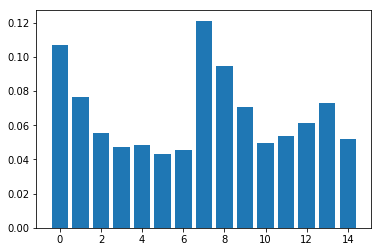

In [137]:
plt.bar(range(len(bst.feature_importances_)), bst.feature_importances_)
plt.show()

# The following are for test purpose only, please ignore

In [434]:
%xdel all_2_merged
%xdel test_m
%xdel x_test2
%xdel all_y
%xdel y_train
%xdel y_train2
%xdel meta_test

NameError: name 'meta_test' is not defined


In [435]:
# Check memory footprint
import gc
gc.collect()

#%whos
import sys
#sys.getrefcount(all_2_merged)
#%reset array
#%xdel all_2_monthly
#%reset all_2_monthly
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))/1000000, 'MB') for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('items_m', 6.696108, 'MB'),
 ('test', 5.140904, 'MB'),
 ('items', 3.8367, 'MB'),
 ('y_valid', 3.810776, 'MB'),
 ('preds', 3.427224, 'MB'),
 ('metas_pred', 2.570504, 'MB'),
 ('sub', 2.570504, 'MB'),
 ('pred_lr', 1.713696, 'MB'),
 ('pred', 0.856896, 'MB'),
 ('pred_clf', 0.856896, 'MB'),
 ('train_item_ids', 0.524512, 'MB'),
 ('test_item_ids', 0.131296, 'MB'),
 ('glb_df', 0.073748, 'MB'),
 ('all_3_prev', 0.068472, 'MB'),
 ('all_3_right', 0.068472, 'MB'),
 ('diff', 0.032992, 'MB'),
 ('item_categories', 0.01139, 'MB'),
 ('shops', 0.00833, 'MB'),
 ('RandomForestRegressor', 0.002, 'MB'),
 ('Lasso', 0.001464, 'MB'),
 ('LinearRegression', 0.001184, 'MB'),
 ('meta_features', 0.001072, 'MB'),
 ('features', 0.000888, 'MB'),
 ('s1', 0.000736, 'MB'),
 ('date', 0.0004, 'MB'),
 ('product', 0.0004, 'MB'),
 ('timedelta', 0.0004, 'MB'),
 ('importantfs', 0.000344, 'MB'),
 ('all_base_features', 0.000288, 'MB'),
 ('features2', 0.000264, 'MB'),
 ('col_rename', 0.00024, 'MB'),
 ('q', 0.00024, 'MB'),
 ('s2', 

## Create new feature: average of item_cnt_day

In [149]:
# Compute the monthly average based on shop_id, item_id, item_category_id, shop_id + item_id
all_m2 = pd.read_csv('./all_m2.csv', dtype={'date':'str'})
groupbys = [['date_block_num', 'shop_id'], ['date_block_num', 'item_id'], ['date_block_num', 'shop_id', 'item_id'], ['date_block_num', 'item_category_id']]
newvcols = ['shop_monthly', 'item_monthly', 'shop_item_monthly', 'item_cat_monthly']
datecol= 'date_block_num'
targetcol = 'item_cnt_day'
ops = ['mean']
features3, all_3 = create_features(all_m2, groupbys, newvcols, ops, targetcol, datecol)

Generating feature:  ['date_block_num', 'shop_id'] - shop_monthly - mean
Generating feature:  ['date_block_num', 'item_id'] - item_monthly - mean
Generating feature:  ['date_block_num', 'shop_id', 'item_id'] - shop_item_monthly - mean
Generating feature:  ['date_block_num', 'item_category_id'] - item_cat_monthly - mean


In [151]:
all_3.to_csv('./all_3_mean_cnt.csv', index=False)
write_list(features3, './features3.txt')

In [152]:
# Drop duplicates of combination (date_block_num, shop_id, item_id), the rows shall be identical except 'date' column
all_3_cleaned = all_3.drop_duplicates(subset=['date_block_num', 'item_id', 'shop_id'], inplace=False)
all_3_cleaned.to_csv('./all_3_cleaned_mean_cnt.csv', index=False)
len(all_3), len(all_3_cleaned)

(3150049, 1823324)

In [ ]:
all_3_cleaned = pd.read_csv('./all_3_cleaned_mean_cnt.csv')

In [156]:
for f in features3:
    all_3_cleaned[f] = all_3_cleaned[f].fillna(0)    
all_3_cleaned.to_csv('./all_3_cleaned_filled_mean_cnt.csv', index=False)

C:\Users\zhang\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [157]:
all_3_cleaned.drop(columns=['date', 'yyyy', 'mm', 'item_price', 'item_cnt_day', 'shop_name', 'item_name', 'item_category_name'], inplace=True)
all_3_cleaned.to_csv('./all_3_merged_filled_cleaned.csv', index=False)

C:\Users\zhang\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [165]:
#Create lagged features

In [168]:
%%time
lags = [1,2,3,4,5,6,12]
test_date_num = 34
datecol= 'date_block_num'
print('original length of all_2_merged: ', len(all_3_cleaned))
groupbys = [['date_block_num', 'shop_id'], ['date_block_num', 'item_id'], ['date_block_num', 'shop_id', 'item_id'], ['date_block_num', 'item_category_id']]
base_feas = features3
kcols = [['shop_id'], ['item_id'], ['shop_id', 'item_id'], ['item_category_id']]

for lag in lags:
    all_3_left = all_3_cleaned[['date_block_num', 'shop_id', 'item_id', 'item_category_id']].copy()
    print('******** lag ' + str(lag) + ' ********')
    for idx, groupby in enumerate(groupbys):
        feas = [base_feas[idx]]
        kcol = kcols[idx]
        print('Working on groups: ', groupby)
        print('list of features to work on: ', feas)
        cols = groupby + [feas
        all_3_right = all_3_cleaned[cols]
        all_3_right = all_3_right.drop_duplicates(subset=groupby, inplace=False)
        print('# of rows for groupby: ', len(all_3_right))
        
        #Use previous value in the order of date_block_num to fill data that not handled by normal lag operation
        #e.g. date_block_num: 3,5,7,8,9,10 can't fill lag of month 5, 7, 12 etc.
        all_3_prev = all_3_right.copy()
        for f in feas:
            prev_col = 'prev_' + f
            all_3_prev[prev_col] = all_3_prev.groupby(kcol)[f].shift(lag)
            #glb_col = 'glb_' + f #apply global median for first
            #df = all_3_prev.groupby(kcol)[f].median() #Data Leak here, need to handle it after using block number
            
            #df = df.reset_index()
            #df.rename(columns={f:glb_col}, inplace=True)
            #all_3_prev = all_3_prev.merge(df, left_on=kcol, right_on=kcol, how='left')
            #all_3_prev[prev_col] = all_3_prev.apply(lambda r: r[glb_col] if np.isnan(r[prev_col]) else r[prev_col] , axis=1)
            #all_3_prev.drop(columns=[glb_col], inplace=True)
            
        all_3_prev.drop(columns=feas, inplace=True)
    
        print('Generating lag features: ', groupby, '-', lag)        
        all_3_right[datecol] = all_3_right[datecol] + lag
        all_3_left = all_3_left.merge(all_3_right, left_on = groupby, right_on = groupby, how='left' )
        all_3_left = all_3_left.merge(all_3_prev, left_on = groupby, right_on = groupby, how='left' )
            
        print('Use previous value to fill NaNs.')
        for f in feas:
            prev_col = 'prev_' + f
            if 'sum' in f:
                all_3_left[f] = all_3_left[f].fillna(0)
            else:
                all_3_left['sign_old'] = all_3_left[f].apply(lambda r: 0 if np.isnan(r) else 1)
                all_3_left['sign_new'] = 1 - all_3_left['sign_old']
                all_3_left[f] = all_3_left[f].apply(lambda r: -999 if np.isnan(r) else r)
                all_3_left[f] = all_3_left['sign_old'] * all_3_left[f] + all_3_left['sign_new'] * all_3_left[prev_col]
            all_3_left.drop(columns=[prev_col], inplace=True)
        
        all_3_left.drop(columns=['sign_old', 'sign_new'], inplace=True)
            
        col_rename = {old:old+'_lag_' + str(lag) for old in feas}
        all_3_left.rename(index=str, columns=col_rename, inplace=True)
        print('--------------------------')

    
    lagged_filename = './all_3_avg_cnt_lag_' + str(lag) + '.csv'
    print('Saving data to file: ', lagged_filename)
    all_3_left.to_csv(lagged_filename, index=False)
    
print('Finished generating lag features.')

original length of all_2_merged:  1823324
******** lag 1 ********
Working on groups:  ['date_block_num', 'shop_id']
list of features to work on:  ['shop_monthly_mean']
# of rows for groupby:  1628
Generating lag features:  ['date_block_num', 'shop_id'] - 1
Use previous value to fill NaNs.
--------------------------
Working on groups:  ['date_block_num', 'item_id']
list of features to work on:  ['item_monthly_mean']
# of rows for groupby:  239012
Generating lag features:  ['date_block_num', 'item_id'] - 1
Use previous value to fill NaNs.
--------------------------
Working on groups:  ['date_block_num', 'shop_id', 'item_id']
list of features to work on:  ['shop_item_monthly_mean']
# of rows for groupby:  1823324
Generating lag features:  ['date_block_num', 'shop_id', 'item_id'] - 1
Use previous value to fill NaNs.
--------------------------
Working on groups:  ['date_block_num', 'item_category_id']
list of features to work on:  ['item_cat_monthly_mean']
# of rows for groupby:  2139
Gener

In [170]:
#Remove 2013 data
lags = [1,2,3,4,5,6,12]
for lag in lags:
    lagged_filename = './all_3_avg_cnt_lag_' + str(lag) + '.csv'
    print('Removing 2013 data for ', lagged_filename)
    all_3_lagged = pd.read_csv(lagged_filename, dtype={'date':'str'})
    all_3_reduced = all_3_lagged[all_3_lagged['date_block_num']>=12]
    for f in features3:
        lf = f + '_lag_' + str(lag)
        all_3_reduced[lf] = all_3_reduced[lf].fillna(0)
    outf = './all_3_reduced_avg_cnt_lag_' + str(lag) + '.csv'
    all_3_reduced.to_csv(outf, index=False)

Removing 2013 data for  ./all_3_avg_cnt_lag_1.csv


C:\Users\zhang\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Removing 2013 data for  ./all_3_avg_cnt_lag_2.csv
Removing 2013 data for  ./all_3_avg_cnt_lag_3.csv
Removing 2013 data for  ./all_3_avg_cnt_lag_4.csv
Removing 2013 data for  ./all_3_avg_cnt_lag_5.csv
Removing 2013 data for  ./all_3_avg_cnt_lag_6.csv
Removing 2013 data for  ./all_3_avg_cnt_lag_12.csv


In [171]:
features1 = read_list('./features1.txt')
features2 = read_list('./features2.txt')
all_base_features = features1 + features2
selected_features = [f for f in all_base_features if 'sum' in f or 'mean' in f]
selected_features

['shop_monthly_sum',
 'item_monthly_sum',
 'shop_item_monthly_sum',
 'item_cat_monthly_sum',
 'shop_price_mean',
 'item_price_mean',
 'shop_item_price_mean',
 'item_cat_price_mean',
 'shop_monthly_mean',
 'item_monthly_mean',
 'shop_item_monthly_mean',
 'item_cat_monthly_mean']

## Select important features only and combine lags

In [185]:
lagged_filename = './all_3_reduced_avg_cnt_lag_' + str(1) + '.csv'
all_3 = pd.read_csv(lagged_filename)
lags = [2,3,4,5,6,12]
for lag in lags:
    lagged_filename = './all_3_reduced_avg_cnt_lag_' + str(lag) + '.csv'
    all_3_reduced = pd.read_csv(lagged_filename)
    all_3 = all_3.merge(all_3_reduced, left_on=merge_cols, right_on = merge_cols, how='left')
    
all_3 = all_3.merge(all_3_targets, left_on = merge_cols, right_on = merge_cols, how='left')    
rm_cols = [c for c in all_3.columns if 'item_category_id' in c and 'item_category_id' != c]
all_3.drop(columns=rm_cols, inplace=True)
all_3.to_csv('./all_3_avg_cnt_combined.csv')

In [178]:
def combine_lag_features():
    print('Compute meta features for model: ', model)
    drop_cols = ['date_block_num', 'target']
    target = 'target'
    merge_cols = ['date_block_num', 'shop_id', 'item_id']
    lags = [1,2,3,4,5,6,12]
    for lag in lags:
        fn = './all_3_reduced_lag_' + str(lag) + '.csv'
        print('Loading lag ', lag, ' features from file: ', fn)
        all_3_reduced = pd.read_csv(fn, dtype={'date':'str'})
        fs = [f for f in all_3_reduced.columns if 'sum' in f or 'mean' in f]
        print('features: ', fs)
        cols = merge_cols + fs
        all_3_reduced = all_3_reduced[cols]
        all_3 = all_3_reduced.merge(all_3_targets, left_on = merge_cols, right_on = merge_cols, how='left')

        out_file = './all_3_shortened_lag_' + str(lag) + '.csv'
        print('Writing shortened data to file: ', out_file)
        all_3.to_csv(out_file, index=False)

In [179]:
combine_lag_features()

Compute meta features for model:  prev
Loading lag  1  features from file:  ./all_3_reduced_lag_1.csv
features:  ['shop_price_mean_lag_1', 'shop_monthly_sum_lag_1', 'item_price_mean_lag_1', 'item_monthly_sum_lag_1', 'shop_item_monthly_sum_lag_1', 'shop_item_price_mean_lag_1', 'item_cat_price_mean_lag_1', 'item_cat_monthly_sum_lag_1']
Writing meta features to file:  ./meta_prev_lag_12.csv
Loading lag  2  features from file:  ./all_3_reduced_lag_2.csv
features:  ['shop_price_mean_lag_2', 'shop_monthly_sum_lag_2', 'item_price_mean_lag_2', 'item_monthly_sum_lag_2', 'shop_item_monthly_sum_lag_2', 'shop_item_price_mean_lag_2', 'item_cat_price_mean_lag_2', 'item_cat_monthly_sum_lag_2']
Writing meta features to file:  ./meta_prev_lag_12.csv
Loading lag  3  features from file:  ./all_3_reduced_lag_3.csv
features:  ['shop_price_mean_lag_3', 'shop_monthly_sum_lag_3', 'item_price_mean_lag_3', 'item_monthly_sum_lag_3', 'shop_item_monthly_sum_lag_3', 'shop_item_price_mean_lag_3', 'item_cat_price_mea

In [196]:
lags = [1, 2,3,4,5,6,12]
for lag in lags:
    in_file = './all_3_shortened_lag_' + str(lag) + '.csv'
    print('combining file: ', in_file)
    all_3_reduced = pd.read_csv(in_file)
    all_3_reduced.drop(columns=['target'], inplace=True)
    all_3 = all_3.merge(all_3_reduced, left_on=merge_cols, right_on = merge_cols, how='left')

all_3.to_csv('./all_combined.csv', index=False)    

combining file:  ./all_3_shortened_lag_1.csv
combining file:  ./all_3_shortened_lag_2.csv
combining file:  ./all_3_shortened_lag_3.csv
combining file:  ./all_3_shortened_lag_4.csv
combining file:  ./all_3_shortened_lag_5.csv
combining file:  ./all_3_shortened_lag_6.csv
combining file:  ./all_3_shortened_lag_12.csv


In [204]:
train = all_3[all_3['date_block_num']<34]
test = all_3[all_3['date_block_num']==34]
features = list(set(all_3.columns) - set(['date_block_num','target']))
target = 'target'
x_train = train[features]
y_train = train[target]
x_test = test[features]

In [206]:
bst = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, gamma=0, subsample=0.8,
                           colsample_bytree=1.0, max_depth=6, silent=False, n_jobs=4)
bst.fit(x_train,y_train, verbose=True, eval_set=[(x_train, y_train)], eval_metric=['rmse'])    
pred = bst.predict(x_test)
pred = np.clip(pred, 0, 20)

[0]	validation_0-rmse:3.52452
[1]	validation_0-rmse:3.42997
[2]	validation_0-rmse:3.34228
[3]	validation_0-rmse:3.2611
[4]	validation_0-rmse:3.18499
[5]	validation_0-rmse:3.11428
[6]	validation_0-rmse:3.04931
[7]	validation_0-rmse:2.98867
[8]	validation_0-rmse:2.93218
[9]	validation_0-rmse:2.8799
[10]	validation_0-rmse:2.83094
[11]	validation_0-rmse:2.78619
[12]	validation_0-rmse:2.74506
[13]	validation_0-rmse:2.70683
[14]	validation_0-rmse:2.67106
[15]	validation_0-rmse:2.63835
[16]	validation_0-rmse:2.60843
[17]	validation_0-rmse:2.58013
[18]	validation_0-rmse:2.55279
[19]	validation_0-rmse:2.52816
[20]	validation_0-rmse:2.50609
[21]	validation_0-rmse:2.48503
[22]	validation_0-rmse:2.46491
[23]	validation_0-rmse:2.44703
[24]	validation_0-rmse:2.43023
[25]	validation_0-rmse:2.41424
[26]	validation_0-rmse:2.39965
[27]	validation_0-rmse:2.38396
[28]	validation_0-rmse:2.36942
[29]	validation_0-rmse:2.3582
[30]	validation_0-rmse:2.3473
[31]	validation_0-rmse:2.33697
[32]	validation_0-rmse

[261]	validation_0-rmse:1.9282
[262]	validation_0-rmse:1.92766
[263]	validation_0-rmse:1.92732
[264]	validation_0-rmse:1.92663
[265]	validation_0-rmse:1.92638
[266]	validation_0-rmse:1.92587
[267]	validation_0-rmse:1.92492
[268]	validation_0-rmse:1.9239
[269]	validation_0-rmse:1.92363
[270]	validation_0-rmse:1.92305
[271]	validation_0-rmse:1.92291
[272]	validation_0-rmse:1.9226
[273]	validation_0-rmse:1.92077
[274]	validation_0-rmse:1.92019
[275]	validation_0-rmse:1.91975
[276]	validation_0-rmse:1.91944
[277]	validation_0-rmse:1.91862
[278]	validation_0-rmse:1.91809
[279]	validation_0-rmse:1.91762
[280]	validation_0-rmse:1.91613
[281]	validation_0-rmse:1.91547
[282]	validation_0-rmse:1.91423
[283]	validation_0-rmse:1.91397
[284]	validation_0-rmse:1.91366
[285]	validation_0-rmse:1.91324
[286]	validation_0-rmse:1.91237
[287]	validation_0-rmse:1.91169
[288]	validation_0-rmse:1.91109
[289]	validation_0-rmse:1.91073
[290]	validation_0-rmse:1.90865
[291]	validation_0-rmse:1.9082
[292]	valida

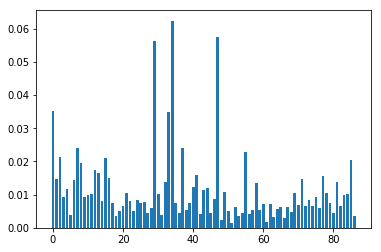

In [211]:
plt.bar(range(len(bst.feature_importances_)), bst.feature_importances_)
plt.show()

In [231]:
a = bst.feature_importances_
idx = np.where(a > 0.01)[0]
importantfs = [features[i] for i in range(0, len(features)) if i in idx]
importantfs

['item_cat_monthly_mean_lag_5',
 'item_monthly_mean_lag_4',
 'shop_price_mean_lag_3',
 'item_cat_price_mean_lag_1',
 'shop_id',
 'item_monthly_mean_lag_2',
 'item_cat_monthly_mean_lag_3',
 'item_cat_monthly_sum_lag_1',
 'shop_item_price_mean_lag_1',
 'item_cat_monthly_mean_lag_1',
 'shop_monthly_mean_lag_12',
 'item_cat_monthly_mean_lag_2',
 'shop_monthly_mean_lag_4',
 'shop_item_monthly_sum_lag_1',
 'item_monthly_sum_lag_2',
 'item_cat_monthly_mean_lag_4',
 'item_monthly_sum_lag_1',
 'item_monthly_mean_lag_1',
 'shop_item_monthly_mean_lag_1',
 'shop_monthly_mean_lag_5',
 'shop_item_monthly_sum_lag_3',
 'shop_monthly_mean_lag_6',
 'shop_monthly_sum_lag_1',
 'item_id',
 'shop_monthly_sum_lag_4',
 'shop_monthly_mean_lag_1',
 'item_cat_monthly_mean_lag_6',
 'shop_monthly_mean_lag_2',
 'item_price_mean_lag_1',
 'item_category_id',
 'shop_monthly_sum_lag_2',
 'item_cat_monthly_mean_lag_12',
 'item_monthly_mean_lag_3',
 'shop_item_monthly_sum_lag_2']

In [242]:
x_train2 = train[importantfs]
y_train2 = np.clip(train[target], 0, 25)
x_test2 = test[importantfs]
bst = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.02, gamma=0, subsample=0.8,
                           colsample_bytree=0.8, max_depth=10, silent=False, n_jobs=4)
bst.fit(x_train2,y_train2, verbose=True, eval_set=[(x_train2, y_train2)], eval_metric=['rmse'])    
pred = bst.predict(x_test2)
pred = np.clip(pred, 0, 20)

[0]	validation_0-rmse:3.10902
[1]	validation_0-rmse:3.07052
[2]	validation_0-rmse:3.0329
[3]	validation_0-rmse:2.99602
[4]	validation_0-rmse:2.9604
[5]	validation_0-rmse:2.92505
[6]	validation_0-rmse:2.89065
[7]	validation_0-rmse:2.857
[8]	validation_0-rmse:2.82469
[9]	validation_0-rmse:2.79261
[10]	validation_0-rmse:2.76175
[11]	validation_0-rmse:2.73197
[12]	validation_0-rmse:2.70256
[13]	validation_0-rmse:2.67355
[14]	validation_0-rmse:2.64603
[15]	validation_0-rmse:2.61885
[16]	validation_0-rmse:2.59271
[17]	validation_0-rmse:2.56656
[18]	validation_0-rmse:2.54207
[19]	validation_0-rmse:2.51732
[20]	validation_0-rmse:2.49338
[21]	validation_0-rmse:2.46954
[22]	validation_0-rmse:2.44668
[23]	validation_0-rmse:2.42498
[24]	validation_0-rmse:2.40294
[25]	validation_0-rmse:2.38172
[26]	validation_0-rmse:2.36195
[27]	validation_0-rmse:2.34195
[28]	validation_0-rmse:2.3227
[29]	validation_0-rmse:2.3041
[30]	validation_0-rmse:2.28583
[31]	validation_0-rmse:2.26753
[32]	validation_0-rmse:2

[261]	validation_0-rmse:1.48026
[262]	validation_0-rmse:1.4797
[263]	validation_0-rmse:1.47899
[264]	validation_0-rmse:1.47842
[265]	validation_0-rmse:1.47779
[266]	validation_0-rmse:1.47683
[267]	validation_0-rmse:1.47616
[268]	validation_0-rmse:1.47576
[269]	validation_0-rmse:1.47513
[270]	validation_0-rmse:1.47436
[271]	validation_0-rmse:1.47369
[272]	validation_0-rmse:1.47307
[273]	validation_0-rmse:1.47243
[274]	validation_0-rmse:1.47193
[275]	validation_0-rmse:1.47115
[276]	validation_0-rmse:1.47072
[277]	validation_0-rmse:1.47028
[278]	validation_0-rmse:1.4696
[279]	validation_0-rmse:1.46913
[280]	validation_0-rmse:1.4685
[281]	validation_0-rmse:1.4678
[282]	validation_0-rmse:1.46747
[283]	validation_0-rmse:1.46702
[284]	validation_0-rmse:1.46663
[285]	validation_0-rmse:1.46599
[286]	validation_0-rmse:1.46567
[287]	validation_0-rmse:1.46526
[288]	validation_0-rmse:1.46458
[289]	validation_0-rmse:1.46416
[290]	validation_0-rmse:1.46366
[291]	validation_0-rmse:1.46292
[292]	valida

[518]	validation_0-rmse:1.36477
[519]	validation_0-rmse:1.36373
[520]	validation_0-rmse:1.36342
[521]	validation_0-rmse:1.36291
[522]	validation_0-rmse:1.36279
[523]	validation_0-rmse:1.36211
[524]	validation_0-rmse:1.36183
[525]	validation_0-rmse:1.36155
[526]	validation_0-rmse:1.36057
[527]	validation_0-rmse:1.36013
[528]	validation_0-rmse:1.35956
[529]	validation_0-rmse:1.35928
[530]	validation_0-rmse:1.35907
[531]	validation_0-rmse:1.3588
[532]	validation_0-rmse:1.35855
[533]	validation_0-rmse:1.35845
[534]	validation_0-rmse:1.35779
[535]	validation_0-rmse:1.35748
[536]	validation_0-rmse:1.3568
[537]	validation_0-rmse:1.35625
[538]	validation_0-rmse:1.35583
[539]	validation_0-rmse:1.35556
[540]	validation_0-rmse:1.35534
[541]	validation_0-rmse:1.35517
[542]	validation_0-rmse:1.35484
[543]	validation_0-rmse:1.35453
[544]	validation_0-rmse:1.35418
[545]	validation_0-rmse:1.35385
[546]	validation_0-rmse:1.35323
[547]	validation_0-rmse:1.35304
[548]	validation_0-rmse:1.35264
[549]	vali

[775]	validation_0-rmse:1.28437
[776]	validation_0-rmse:1.28412
[777]	validation_0-rmse:1.28366
[778]	validation_0-rmse:1.2835
[779]	validation_0-rmse:1.28275
[780]	validation_0-rmse:1.28241
[781]	validation_0-rmse:1.28223
[782]	validation_0-rmse:1.28206
[783]	validation_0-rmse:1.28191
[784]	validation_0-rmse:1.28169
[785]	validation_0-rmse:1.28133
[786]	validation_0-rmse:1.28115
[787]	validation_0-rmse:1.28085
[788]	validation_0-rmse:1.28044
[789]	validation_0-rmse:1.28029
[790]	validation_0-rmse:1.2802
[791]	validation_0-rmse:1.27992
[792]	validation_0-rmse:1.27919
[793]	validation_0-rmse:1.27899
[794]	validation_0-rmse:1.27893
[795]	validation_0-rmse:1.27885
[796]	validation_0-rmse:1.27842
[797]	validation_0-rmse:1.27806
[798]	validation_0-rmse:1.27766
[799]	validation_0-rmse:1.27731
[800]	validation_0-rmse:1.27717
[801]	validation_0-rmse:1.27695
[802]	validation_0-rmse:1.27682
[803]	validation_0-rmse:1.27661
[804]	validation_0-rmse:1.27618
[805]	validation_0-rmse:1.27604
[806]	vali

In [240]:
sub = pd.DataFrame({'ID':range(0,len(pred)), 'item_cnt_month':pred})
sub.to_csv('./sub_new_xgb_1.csv', index=False)